# CME538 - Introduction to Data Science
## Assignment 10 - Flight Delay Classification

#### Learning Objectives
After completing this assignment, you should be comfortable:

- Feature engineering
- Building a data pipeline using pandas
- Identifying informative variables through EDA
- Feature engineering with categorical variables
- Classification using logistic regression and random forests
- Testing for class imbalance
- Classification metrics

**Marking Breakdown**

Question | Points
--- | ---
Question 1a | 1
Question 1b | 1
Question 1c | 1
Question 1d | 1
Question 2a | 1
Question 2b | 1
Question 2c | 1
Question 2d | 1
Question 3a | 1
Question 3b | 1
Question 3c | 1
Question 3d | 1
Question 3e | 1
Question 4a | 1
Question 4b | 1
Question 4c | 1
Question 4d | 1
Total | 17

## Setup Notebook

In [1]:
# Import 3rd party libraries
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt

# Configure Notebook
%matplotlib inline
plt.style.use('fivethirtyeight')
sns.set_context("notebook")
import warnings
warnings.filterwarnings('ignore')

In [2]:
!pip install folium

In [3]:
import folium
from folium import Marker

# Overview

In this assignment, you will use all the tools and knowledge that you've learned in class to explore and model flight delays from New York City airports (LaGuadia Airport, John F. Kennedy International Airport, and Newark International Airport) in 2013. You will create a classification model that predicts the whether or not a flight will be delayed at take-off. You're working for a company that is exploring the possibility of building an app that notifies travellers if their flight is likely to be delayed or cancelled. 

Oops, looks like Google has already done [this](https://techcrunch.com/2018/01/31/google-flights-will-now-predict-airline-delays-before-the-airlines-do/) ;)

In [120]:
# Create a map of Toronto
map_1 = folium.Map(location=[40.7484, -73.9857], 
                   tiles='cartodbpositron', 
                   zoom_start=10)

# Add points to the map
Marker([40.7769, -73.8740], popup='LaGuardia Airport (LGA)').add_to(map_1)
Marker([40.6413, -73.7781], popup='John F. Kennedy International Airport (JFK)').add_to(map_1)
Marker([40.6895, -74.1745], popup='Newark Liberty International Airport (EWR)').add_to(map_1)

# Display map
map_1

# The Data

This dataset consists of 4 files from the 2013.

**flights.csv**
This file contains data for all flights that departed New York City airports (LaGuadia Airport, John F. Kennedy International Airport, and Newark International Airport) in 2013 and includes each flight's on-time performance. 

**Columns of the `flights.csv` include:**
- `year`: year of departure
- `month`: month of departure
- `day`: day of departure
- `sched_dep_time`: scheduled departure time (format HHMM or HMM), local timezone (GMT)   
- `sched_arr_time`: scheduled arrival time (format HHMM or HMM), local timezone (GMT)  
- `dep_delay`: departure delay in minutes where negative times represent early departures
- `arr_delay`: arrival delay in minutes where negative times represent early arrivals
- `carrier`: two letter carrier abbreviation (see `airlines.csv`)
- `flight`: flight number
- `tailnum`: plane tail number (See `planes.csv`)
- `origin`: flight origin (See `airports.csv`)
- `dest`: flight destination (See `airports.csv`)
- `air_time`: amount of time spent in the air in minutes
- `distance`: distance between airports in miles
- `hour`: hour of scheduled departure 
- `minute`: minute of scheduled departure
- `time_hour`: scheduled date and hour of the flight as a POSIXct date, which along with origin, can be used to join `flights.csv` to `weather.csv`. 

Source: RITA, Bureau of transportation statistics, https://www.transtats.bts.gov/DL_SelectFields.
asp?Table_ID=236


**Columns of the `weather.csv` include:**
- `origin`: Weather station name, which is named `origin` to facilitate merging with `flights.csv` data
- `year`: year of recording
- `month`: month of recording
- `day`: day of recording
- `hour`: hour of recording
- `temp`: temperature in fahrenheit
- `dewp`: dew point in fahrenheit
- `humid`: relative humidity
- `wind_dir`: wind direction in degrees
- `wind_speed`: wind speed in mph
- `wind_gust`: wind gust speed in mph
- `precip`: precipitation in inches
- `pressure`: sea level pressure in millibars
- `visib`: visibility in miles
- `time_hour`: date and hour of the recording as a POSIXct date

Source: ASOS download from Iowa Environmental Mesonet, https://mesonet.agron.iastate.edu/
request/download.phtml.

**Columns of the `planes.csv` include:**
- `tailnum`: plane tail number 
- `year`: year manufactured
- `type`: type of plane
- `manufacturer`: plane manufacturer
- `model`: plane model
- `engines`: number of engines
- `seats`: number of seats
- `speed`: average cruising speed in mph
- `engine`: type of engine

Source: FAA Aircraft registry, https://www.faa.gov/licenses_certificates/aircraft_certification/
aircraft_registry/releasable_aircraft_download/

**Columns of the `airlines.csv` include:**
- `carrier`: two letter abbreviation
- `name`: full name

Source: https://www.transtats.bts.gov/DL_SelectFields.asp?Table_ID=236


# Import the datasets
Let's import the four datasets as Pandas DataFrames.

In [5]:
flights = pd.read_csv('flights.csv')
flights.head(2)

,year,month,day,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,carrier,flight,tailnum,origin,dest,air_time,distance,hour,minute,time_hour
0,2013,1,1,517.0,515,2.0,830.0,819,11.0,UA,1545,N14228,EWR,IAH,227.0,1400,5,15,2013-01-01T05:00:00Z
1,2013,1,1,533.0,529,4.0,850.0,830,20.0,UA,1714,N24211,LGA,IAH,227.0,1416,5,29,2013-01-01T05:00:00Z


In [6]:
weather = pd.read_csv('weather.csv')
weather.head()

,origin,year,month,day,hour,temp,dewp,humid,wind_dir,wind_speed,wind_gust,precip,pressure,visib,time_hour
0,EWR,2013,1,1,1,39.02,26.06,59.37,270.0,10.35702,NaN,0.0,1012.0,10.0,2013-01-01T06:00:00Z
1,EWR,2013,1,1,2,39.02,26.96,61.63,250.0,8.05546,NaN,0.0,1012.3,10.0,2013-01-01T07:00:00Z
2,EWR,2013,1,1,3,39.02,28.04,64.43,240.0,11.50780,NaN,0.0,1012.5,10.0,2013-01-01T08:00:00Z
3,EWR,2013,1,1,4,39.92,28.04,62.21,250.0,12.65858,NaN,0.0,1012.2,10.0,2013-01-01T09:00:00Z
4,EWR,2013,1,1,5,39.02,28.04,64.43,260.0,12.65858,NaN,0.0,1011.9,10.0,2013-01-01T10:00:00Z


In [7]:
planes = pd.read_csv('planes.csv')
planes.head(2)

,tailnum,year,type,manufacturer,model,engines,seats,speed,engine
0,N10156,2004.0,Fixed wing multi engine,EMBRAER,EMB-145XR,2,55,NaN,Turbo-fan
1,N102UW,1998.0,Fixed wing multi engine,AIRBUS INDUSTRIE,A320-214,2,182,NaN,Turbo-fan


In [8]:
airlines = pd.read_csv('airlines.csv')
airlines.head(2)

,carrier,name
0,9E,Endeavor Air Inc.
1,AA,American Airlines Inc.


# 1. Data Cleaning and Pre-processing
In this assignment, we'll be constructing a model that predicts whether or not a flight had a delayed departure. For example, consider the first row of the `flights` DataFrame. 

In [9]:
flights.head(5)

,year,month,day,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,carrier,flight,tailnum,origin,dest,air_time,distance,hour,minute,time_hour
0,2013,1,1,517.0,515,2.0,830.0,819,11.0,UA,1545,N14228,EWR,IAH,227.0,1400,5,15,2013-01-01T05:00:00Z
1,2013,1,1,533.0,529,4.0,850.0,830,20.0,UA,1714,N24211,LGA,IAH,227.0,1416,5,29,2013-01-01T05:00:00Z
2,2013,1,1,542.0,540,2.0,923.0,850,33.0,AA,1141,N619AA,JFK,MIA,160.0,1089,5,40,2013-01-01T05:00:00Z
3,2013,1,1,544.0,545,-1.0,1004.0,1022,-18.0,B6,725,N804JB,JFK,BQN,183.0,1576,5,45,2013-01-01T05:00:00Z
4,2013,1,1,554.0,600,-6.0,812.0,837,-25.0,DL,461,N668DN,LGA,ATL,116.0,762,6,0,2013-01-01T06:00:00Z


- `dep_time` = 517 minutes
- `sched_dep_time` = 515 minutes
- `dep_delay` = 2 minutes

This data is telling us that the departure of this flight was delayed by 2 minutes. On the other hand, if we consider the 5th row, 

- `dep_time` = 554 minutes
- `sched_dep_time` = 600 minutes
- `dep_delay` = -6 minutes

we can see that this flight actually departed 6 minutes early (great!).

## Question 1a
Let's investigate the missingness in our dataset and devise a strategy for addressing it. Create a function `show_missing_percentages()` that takes a DataFrame as input and outputs a DataFrame where the index contains the column names of the original DataFrame. The output DataFrame should have two columns. The first column should be named `missing_percentage` and contain the percentage of missing values for a particular column. The second column should be bamed `missing_count` and contain the number of missing values for a particular column. Lastly, sort the rows in descending order.

In [10]:
# Write your code here
def show_missing_percentages(df):
    
    df_missing = pd.DataFrame(index=df.columns, 
                              data={'missing_percentage': df.isnull().sum() * 100 / len(df),
                                    'missing_count': df.isnull().sum()})
    df_missing = df_missing.sort_values('missing_percentage', ascending=False)
    
    return df_missing

Let's try your function out for each DataFrame.

In [11]:
# Flight data
show_missing_percentages(flights)

,missing_percentage,missing_count
arr_delay,2.800081,9430
air_time,2.800081,9430
arr_time,2.587180,8713
dep_time,2.451184,8255
dep_delay,2.451184,8255
tailnum,0.745896,2512
year,0.000000,0
origin,0.000000,0
minute,0.000000,0
hour,0.000000,0


In [12]:
# Weather data
show_missing_percentages(weather)

,missing_percentage,missing_count
wind_gust,79.563469,20778
pressure,10.449933,2729
wind_dir,1.761440,460
wind_speed,0.015317,4
temp,0.003829,1
dewp,0.003829,1
humid,0.003829,1
origin,0.000000,0
year,0.000000,0
month,0.000000,0


In [13]:
# Planes data
show_missing_percentages(planes)

,missing_percentage,missing_count
speed,99.307646,3299
year,2.107164,70
tailnum,0.000000,0
type,0.000000,0
manufacturer,0.000000,0
model,0.000000,0
engines,0.000000,0
seats,0.000000,0
engine,0.000000,0


In [14]:
# Airlines data
show_missing_percentages(airlines)

,missing_percentage,missing_count
carrier,0.0,0
name,0.0,0


### As a quick aside, meet `missingno`
Messy datasets? Missing values? missingno provides a small toolset of flexible and easy-to-use missing data visualizations and utilities that allows you to get a quick visual summary of the completeness (or lack thereof) of your dataset. Just pip install missingno to get started.

In [15]:
!pip install missingno

In [16]:
import missingno as msno

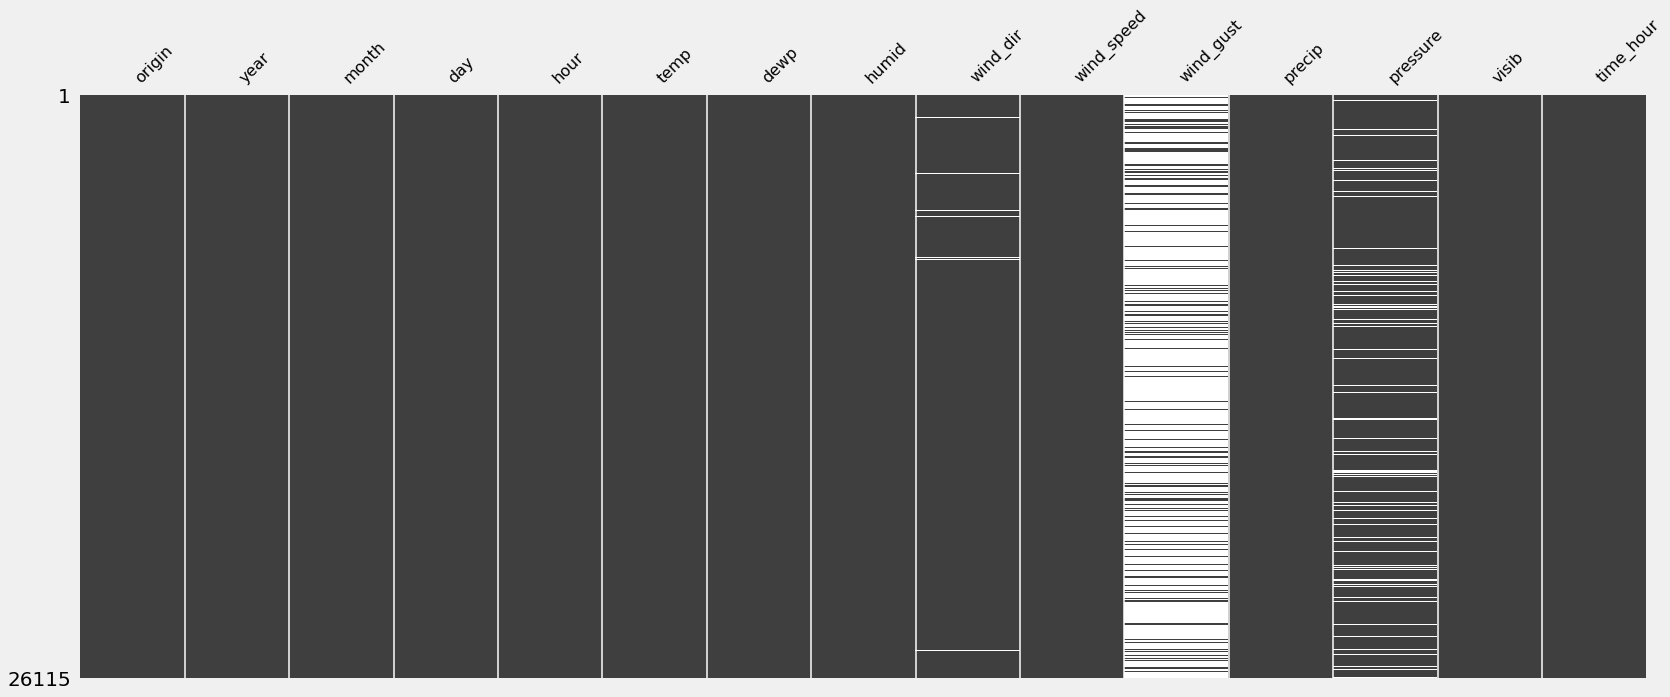

In [17]:
msno.matrix(weather, sparkline=False);

Whoa, that's a nice way to visualize missing data. Learn more [here](https://github.com/ResidentMario/missingno).

## Question 1b
Next, we need to merge `flights`, `weather`, and `airlines`. Create a new DataFrame called `data_merged`. 

`flights` will be our base DataFrame and we want to add `airlines`, `planes`, and `weather`.

In [18]:
flights.shape

(336776, 19)

`flights` has 328,521 rows and therefore, `data_merged` should have 328,521 rows.

`airlines` has a column named `'name'`, which should be changed to `'carrier_name'` in `airlines` before merging.

`planes` has a column named `'year'`, which should be changed to `'plane_year'` in `planes` before merging.

Before adding `weather` columns, drop the column named `'time_hour'` from `weather` because it is also present in `flights`.

In [19]:
# Write your code here

# Rename 'name' to 'carrier_name'
airlines = airlines.rename(columns={'name': 'carrier_name'})

# Change the column name 'year' in planes to 'plane_year'
planes = planes.rename(columns={'year': 'plane_year'})

# Drop 'time_hour' from weather
weather = weather.drop(['time_hour'], axis=1)

# Combine flights and airlines
flights_airlines = pd.merge(flights, airlines, on=['carrier'], how='left')

# Combine flights_airlines and planes
flights_airlines_planes = pd.merge(flights_airlines, planes, on=['tailnum'], how='left')

# Combine flights_airlines_planes and weather
data_merged = pd.merge(flights_airlines_planes, weather, on=['origin', 'year', 'month', 'day', 'hour'], how='left')

# View DataFrame
data_merged.head(2)

,year,month,day,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,carrier,...,engine,temp,dewp,humid,wind_dir,wind_speed,wind_gust,precip,pressure,visib
0,2013,1,1,517.0,515,2.0,830.0,819,11.0,UA,...,Turbo-fan,39.02,28.04,64.43,260.0,12.65858,NaN,0.0,1011.9,10.0
1,2013,1,1,533.0,529,4.0,850.0,830,20.0,UA,...,Turbo-fan,39.92,24.98,54.81,250.0,14.96014,21.86482,0.0,1011.4,10.0


Let's check that out DataFrame has the correct number of rows and columns. You should get `(328521, 37)`.

In [20]:
data_merged.shape

(336776, 37)

Let's use `missingno` to visualize our missing data in `data_merged`. We can see that with the exception of a few missing values in `'arr_delay'` and `'air_time'`, the missingness is in the weather features and plane features.

You may be thinking, why didn't we just remove all missing values at this stage? There are two reasons. The first is that we want flexibility to experiment and learn from EDA and so keeping most of the missingness leaves more options for us. The second is that we're not entirely sure what the missingness measure for some of these columns. For example, with `wind_gusts`, does a missing value mean the data wasn't recorded or does it mean that there were no gusts? We'll explore this more during EDA.

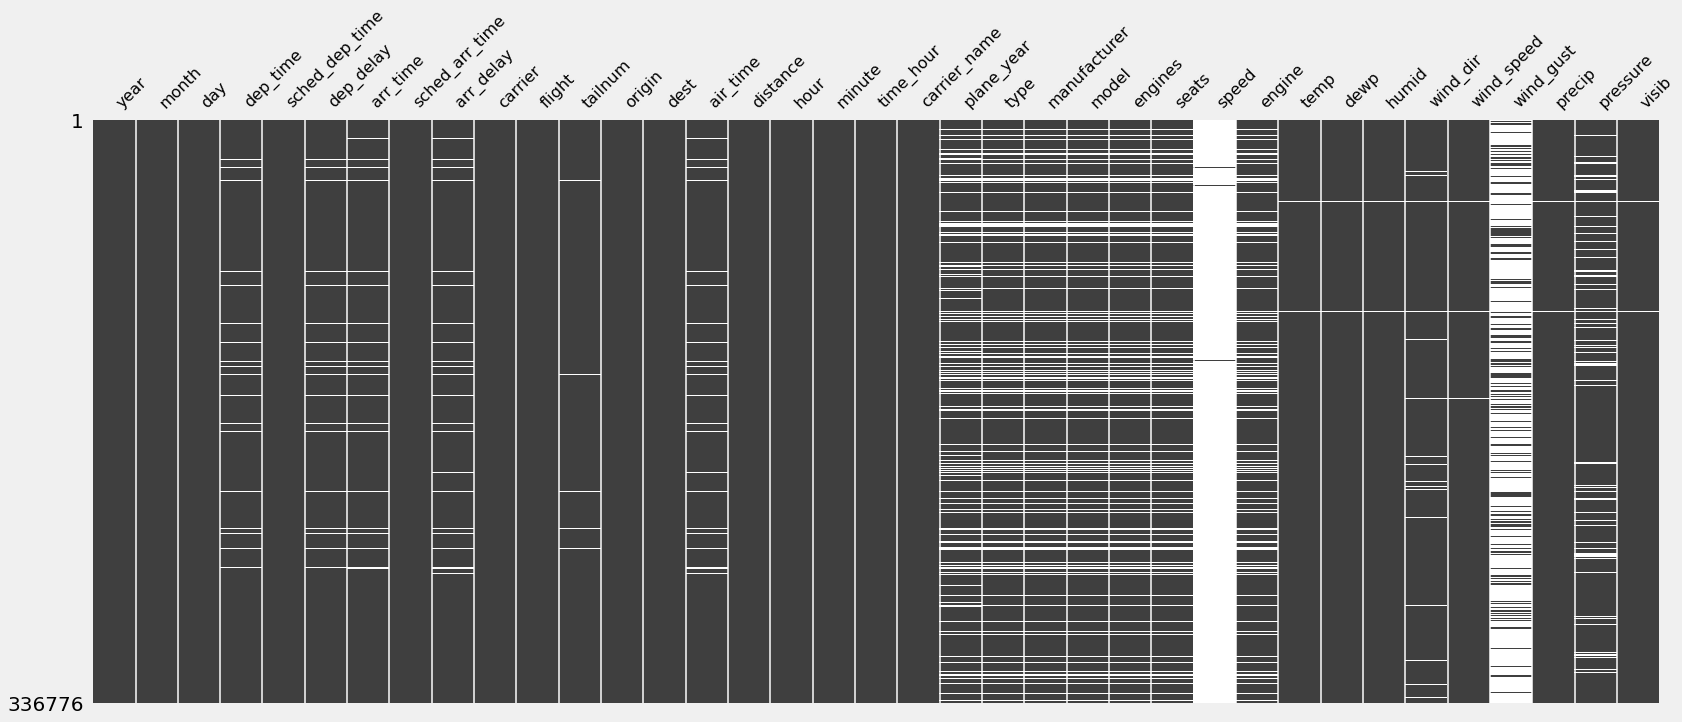

In [21]:
msno.matrix(data_merged, sparkline=False);

## Question 1c
Our model will take on the form $\text{delayed} = f(\text{temperature}, \text{day}, \text{hour}, ...)$ and therefore, we'll need to create our training target. The training target will have the column name `delayed` and will be a binary label which is equal to `1` when a flight is either delayed by more than 15 minutes (`dep_delay` > 15 minutes) or cancelled (`dep_delay` == `NaN`) and `0` otherwise. Create a new column in `flights` called `delayed` for the binary label described above.

During EDA, we'll be looking into a more granular label called `delayed_group`. `delayed_group` contains a string for each row which is equal to `'delayed'` when `dep_delay` > 15 minutes, `'cancelled'` when `dep_delay` == `NaN`, and `'one-time'` otherwise.

Add columns `'delayed'` and `'delayed_group'` to `data_merged`.

In [22]:
# Write your code here
data_merged['delayed'] = data_merged.apply(lambda row: 1 if row['dep_delay'] > 15 or np.isnan(row['dep_delay']) else 0, axis=1)
data_merged['delayed_group'] = data_merged.apply(lambda row: 'delayed' if row['dep_delay'] > 15 else ('cancelled' if np.isnan(row['dep_delay']) else 'on-time'), axis=1)

# View DataFrame
data_merged.head(2)

,year,month,day,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,carrier,...,dewp,humid,wind_dir,wind_speed,wind_gust,precip,pressure,visib,delayed,delayed_group
0,2013,1,1,517.0,515,2.0,830.0,819,11.0,UA,...,28.04,64.43,260.0,12.65858,NaN,0.0,1011.9,10.0,0,on-time
1,2013,1,1,533.0,529,4.0,850.0,830,20.0,UA,...,24.98,54.81,250.0,14.96014,21.86482,0.0,1011.4,10.0,0,on-time


## Question 1d
Lastly, we want to create some reusable pipelines so that we can generate our cleaned and pre-processed in a repeatable and reliable way.

Create a function called `preprocess_data()` that imports `flights`, `weather`, `airlines`, and `planes` and then executes the tasks from Questions `1b`, `1c` and returns `data_merged`. It should also convert `'time_hour'` from a string to a `datetime` object.

In [23]:
# Write your code here
def preprocess_data():
    
    # Import data
    flights = pd.read_csv('flights.csv')
    weather = pd.read_csv('weather.csv')
    airlines = pd.read_csv('airlines.csv')
    planes = pd.read_csv('planes.csv')
    
    # Rename 'name' to 'carrier_name'
    airlines = airlines.rename(columns={'name': 'carrier_name'})

    # Change the column name 'year' in planes to 'plane_year'
    planes = planes.rename(columns={'year': 'plane_year'})

    # Drop 'time_hour' from weather
    weather = weather.drop(['time_hour'], axis=1)

    # Combine flights and airlines
    flights_airlines = pd.merge(flights, airlines, on=['carrier'], how='left')

    # Combine flights_airlines and planes
    flights_airlines_planes = pd.merge(flights_airlines, planes, on=['tailnum'], how='left')

    # Combine flights_airlines_planes and weather
    data_merged = pd.merge(flights_airlines_planes, weather, on=['origin', 'year', 'month', 'day', 'hour'], how='left')
    
    # Generate labels
    data_merged['delayed'] = data_merged.apply(lambda row: 1 if row['dep_delay'] > 15 or np.isnan(row['dep_delay']) else 0, axis=1)
    data_merged['delayed_group'] = data_merged.apply(lambda row: 'delayed' if row['dep_delay'] > 15 else ('cancelled' if np.isnan(row['dep_delay']) else 'on-time'), axis=1)

    # Convert time_hour to a datetime object
    data_merged['time_hour'] = pd.to_datetime(data_merged['time_hour'])
    
    return data_merged

Let's try your function out.

In [24]:
# Preprocess data
data_merged = preprocess_data()

# View DataFrame
data_merged.head(2)

,year,month,day,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,carrier,...,dewp,humid,wind_dir,wind_speed,wind_gust,precip,pressure,visib,delayed,delayed_group
0,2013,1,1,517.0,515,2.0,830.0,819,11.0,UA,...,28.04,64.43,260.0,12.65858,NaN,0.0,1011.9,10.0,0,on-time
1,2013,1,1,533.0,529,4.0,850.0,830,20.0,UA,...,24.98,54.81,250.0,14.96014,21.86482,0.0,1011.4,10.0,0,on-time


We can check the size to make sure we haven't messed anything up. You should get `(328521, 39)`.

In [25]:
data_merged.head()

,year,month,day,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,carrier,...,dewp,humid,wind_dir,wind_speed,wind_gust,precip,pressure,visib,delayed,delayed_group
0,2013,1,1,517.0,515,2.0,830.0,819,11.0,UA,...,28.04,64.43,260.0,12.65858,NaN,0.0,1011.9,10.0,0,on-time
1,2013,1,1,533.0,529,4.0,850.0,830,20.0,UA,...,24.98,54.81,250.0,14.96014,21.86482,0.0,1011.4,10.0,0,on-time
2,2013,1,1,542.0,540,2.0,923.0,850,33.0,AA,...,26.96,61.63,260.0,14.96014,NaN,0.0,1012.1,10.0,0,on-time
3,2013,1,1,544.0,545,-1.0,1004.0,1022,-18.0,B6,...,26.96,61.63,260.0,14.96014,NaN,0.0,1012.1,10.0,0,on-time
4,2013,1,1,554.0,600,-6.0,812.0,837,-25.0,DL,...,24.98,54.81,260.0,16.11092,23.01560,0.0,1011.7,10.0,0,on-time


# 2. Exploratory Data Analysis
Now that our dataset is in more EDA-friendly format, let's jump in and start exploring this dataset. In particular, we want to explore our features and identify some for our baseline model. Remember, want to answer the question, does weather information (features from weather.csv) improve the performance of our model. So, we'll first build a model using features from `flights` and then build another model that uses additional features from `weather`.

Firstly, let's grab our preprocessed dataset using our function.

In [26]:
# Preprocess data for EDA
data_eda = preprocess_data()

# View DataFrame
data_eda.head(2)

,year,month,day,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,carrier,...,dewp,humid,wind_dir,wind_speed,wind_gust,precip,pressure,visib,delayed,delayed_group
0,2013,1,1,517.0,515,2.0,830.0,819,11.0,UA,...,28.04,64.43,260.0,12.65858,NaN,0.0,1011.9,10.0,0,on-time
1,2013,1,1,533.0,529,4.0,850.0,830,20.0,UA,...,24.98,54.81,250.0,14.96014,21.86482,0.0,1011.4,10.0,0,on-time


## Flight Features
First, let's look into flight features such as the airline, day of the week and hour of the day.

## Question 2a
First, let's look at the relationship between flight delays and the airline. Create a bar chart that displays `'carrier_name'` on the y-axis and the number of flight, grouped by `'delayed_group'` on the x-axis. You plot should look something like this.

<br>
<img src="images/airlines_vs_delays.png" alt="drawing" width="600"/>
<br>

Now, here is the tricky part. The order of the airlines on the y-axis should be in descending order from top to bottom accorind to the total (one-time + delayed + cancelled) number of flights for a particular airline.

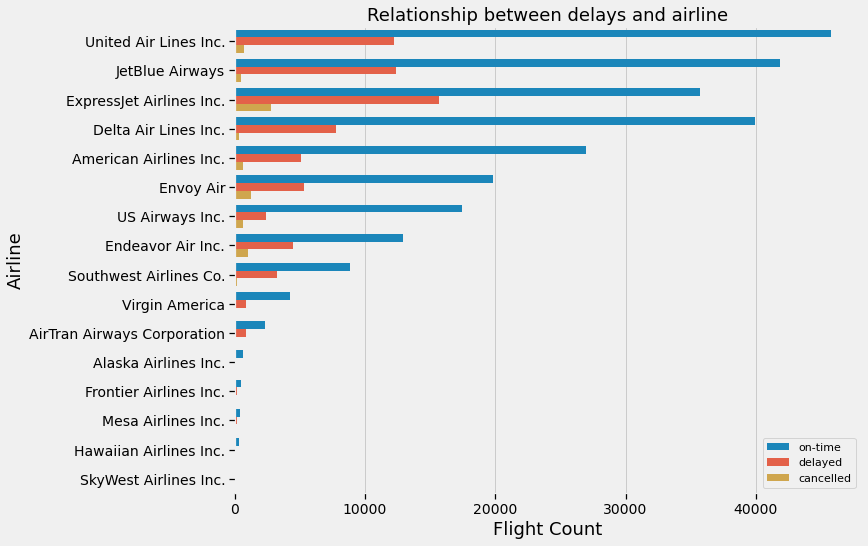

In [27]:
# Write your code here
plt.figure(figsize=(10, 8))
plt.title('Relationship between delays and airline', fontsize=18)
ax = sns.countplot(y='carrier_name', hue='delayed_group', data=data_eda, order=data_eda['carrier_name'].value_counts().index)
ax.legend(loc=4)
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
ax.set_xlabel('Flight Count', fontsize=18)
ax.set_ylabel('Airline', fontsize=18)
plt.show()

## Question 2b
From this plot, its difficult to determine if the airline has an affect on the number of delays or cancellations. United Airlines certainly runs more flights and has more delays and cancellations than American Airlines. However, perhaps the proportion of flights that are delayed or cancelled are the same for both airlines. To overcome this issue with the previous plot, create a new plot that shows the proportion of flights for each airline as opposed to the total count. Your plot should look something like this.

<br>
<img src="images/airlines_vs_delays_proportion.png" alt="drawing" width="600"/>
<br>

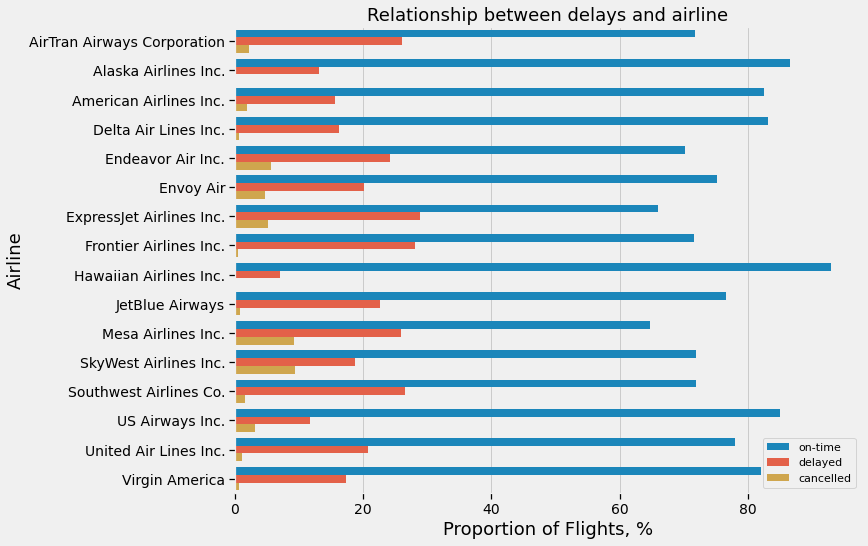

In [28]:
# Write your code here
df_temp = (data_eda['delayed_group']
            .groupby(data_eda['carrier_name'])
            .value_counts(normalize=True)
            .rename('proportion')
            .reset_index())
df_temp['proportion'] = df_temp['proportion'] * 100


plt.figure(figsize=(10, 8))
plt.title('Relationship between delays and airline', fontsize=18)
ax = sns.barplot(y='carrier_name', x='proportion', hue='delayed_group', data=df_temp)
ax.legend(loc=4)
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
ax.set_xlabel('Proportion of Flights, %', fontsize=18)
ax.set_ylabel('Airline', fontsize=18)
plt.show()

With this plot, we can more clearly see that some airlines, such as **ExpressJet Airlines** have significantly more delays or cancellations than others, such as **Delta Airlines**. It is important to note, however, that **Mesa Airlines** has the larges proportion of delayed or cancelled flight but the number of flights operated by **Mesa Airlines** is very small relative to most other airlines.

Next, let's investigate the effect of month, day, and hour on flight delays.

## Question 2c
First, let's look at `'delayed'` as a function of `'month'`. Create a plot that shows the number of delayed flights (`'delayed' == 1`) and on-time flights (`'delayed' == 0`) for each month. Should you use a bar chart (stacked?), a line plot, catter plot, histogram? Use what we learned in Week 4 to generate the most descriptive plot. Months should be displayed as strings (`March`) not an integer (`3`) and the legend should show delays as `'delayed'` and `'one-time'` not `1` and `0`. Months should be ordered properly (January - December).

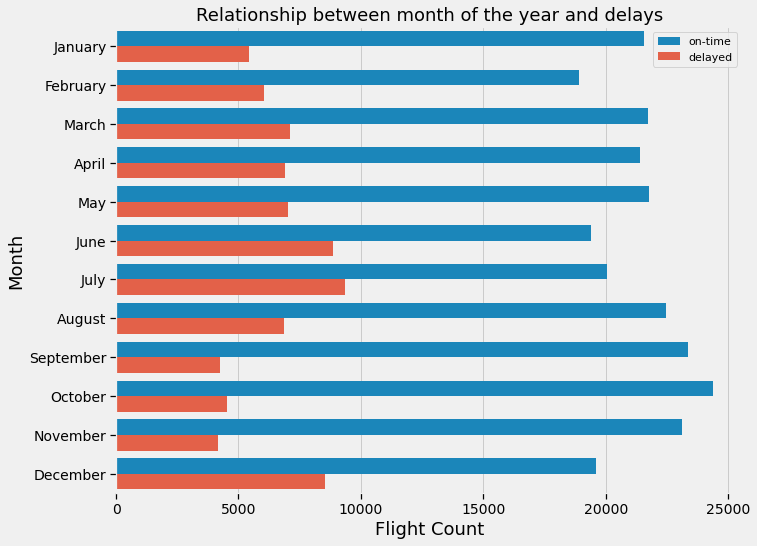

In [29]:
# Write your code here
import calendar
df_temp = data_eda.copy()
df_temp['month'] = df_temp['month'].map(lambda val: calendar.month_name[val])
df_temp['delayed'] = df_temp['delayed'].map(lambda val: 'delayed' if val == 1 else 'on-time')

plt.figure(figsize=(10, 8))
plt.title('Relationship between month of the year and delays', fontsize=18)
ax = sns.countplot(y='month', hue='delayed', data=df_temp, order=[calendar.month_name[month] for month in range(1, 13)])
ax.legend(loc=1)
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
ax.set_xlabel('Flight Count', fontsize=18)
ax.set_ylabel('Month', fontsize=18)
plt.show()

From this plot, we can see that certain months such as July, June, and December contribute the highest proportion od delays compared to other months. 

There are many more flight features including the day of the month, day of the week, and hour of the day. Feel free to explore these in the cell below. This will not be marked but is good practice.

In [30]:
# Write your code here (if you want to)

## Weather Features
Next, let's look into weather features such as the temperature, wind speed, and precipitation.

## Question 2d
First, let's look into the `'wind_gust'` feature. This feature could be helpful for predicting a delay because strong and unpredictable gusts could keep planes grounded. However, this feature has a lot of missing values (almost 80%).

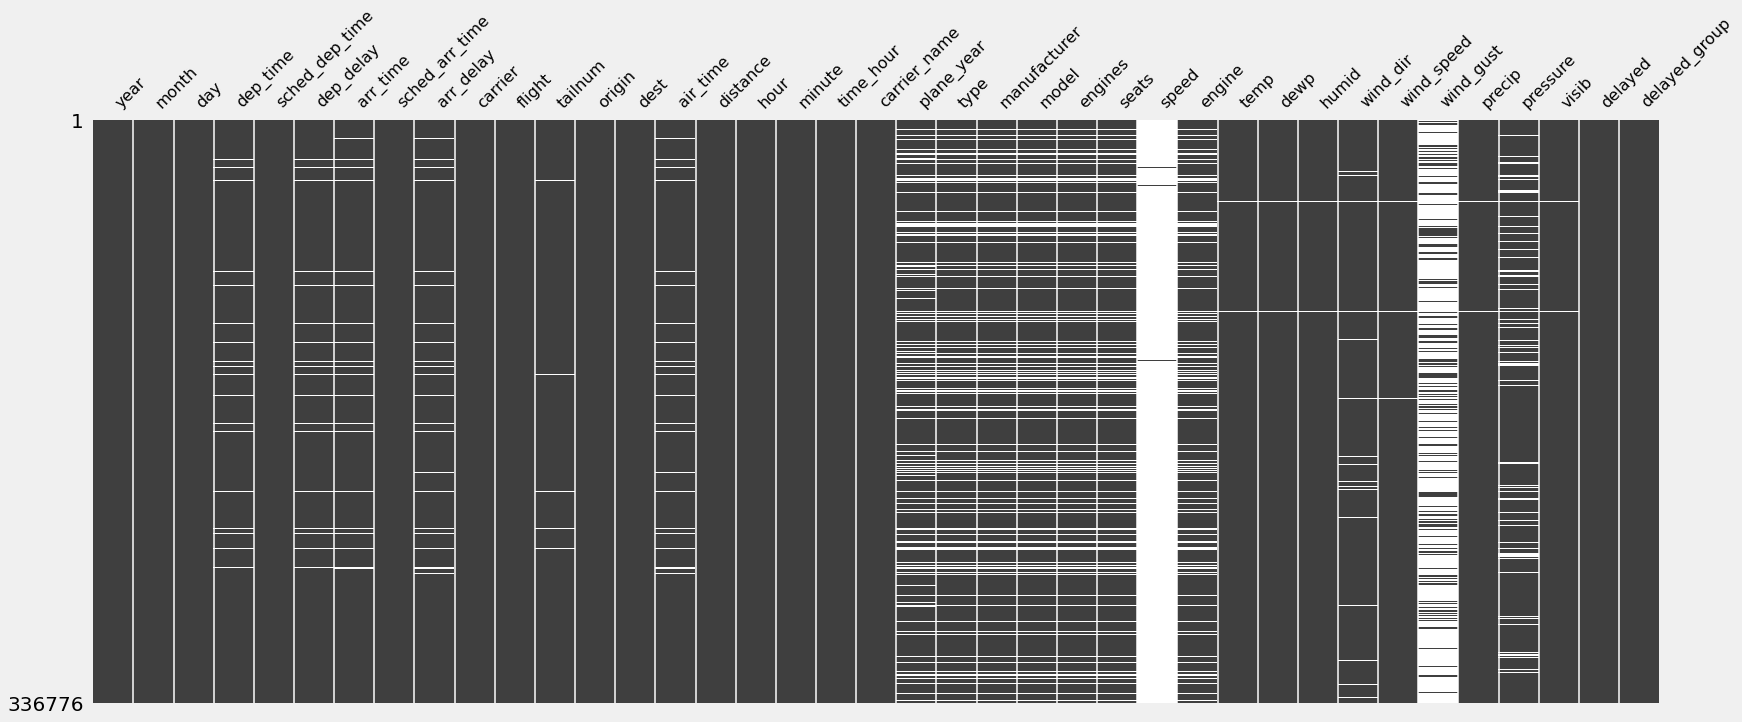

In [31]:
msno.matrix(data_eda, sparkline=False);

Before we can use this, we need to confirm whether or not the missing data means that there were no gusts or if it means that the data was simply not recorded (recording or database error). If a missing value means that the data was not recorded, then we cannot use this feature because 80% of the data is missing.

The quesiton is, can we use `'wind_gust'` as a feature in our model. Create a figure to help answer this question and justify your decision in the textbox below.

Hint: If a missing value for `'wind_gust'` means that there was no gust, we might expect the `'wind_speed'` to be similarly low at that time compared to when a gust was recorded? Consider making a vew binary feature to help (gust/no-gust).

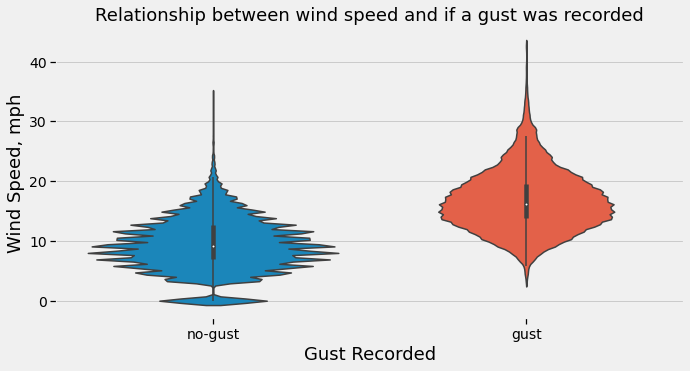

In [32]:
# Write your code here
df_temp = data_eda.copy()
df_temp['gust'] = df_temp['wind_gust'].map(lambda val: 'no-gust' if np.isnan(val) else 'gust')

plt.figure(figsize=(10, 5))
plt.title('Relationship between wind speed and if a gust was recorded', fontsize=18)
ax = sns.violinplot(x='gust', y='wind_speed', data=df_temp)
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
ax.set_xlabel('Gust Recorded', fontsize=18)
ax.set_ylabel('Wind Speed, mph', fontsize=18)
plt.show()

Explain your decision here.

**Answer:** *As we see from the plot above, lower `'wind_speed'` are recorded when there is a missing value for `'wind_gust'`. This suggests that missing values actually tell us something about the presence of wind gusts and this feature should not be discarded.*

Let's investigate the relationship between (`'temp'`, `'humid'`, `'wind_speed'`, `'wind_dir'`, `'pressure'`, `'precip'`, `'visib'`) and `'delayed'`. Generate a violin plot for each feature.

`'temp'`

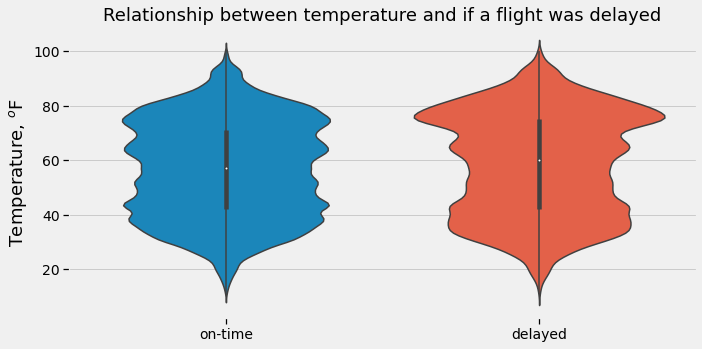

In [33]:
# Write your code here
df_temp = data_eda.copy()
df_temp['delayed'] = df_temp['delayed'].map(lambda val: 'delayed' if val == 1 else 'on-time')

plt.figure(figsize=(10, 5))
plt.title('Relationship between temperature and if a flight was delayed', fontsize=18)
ax = sns.violinplot(x='delayed', y='temp', data=df_temp)
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
ax.set_xlabel('', fontsize=18)
ax.set_ylabel('Temperature, $^{o}$F', fontsize=18)
plt.show()

`'humid'`

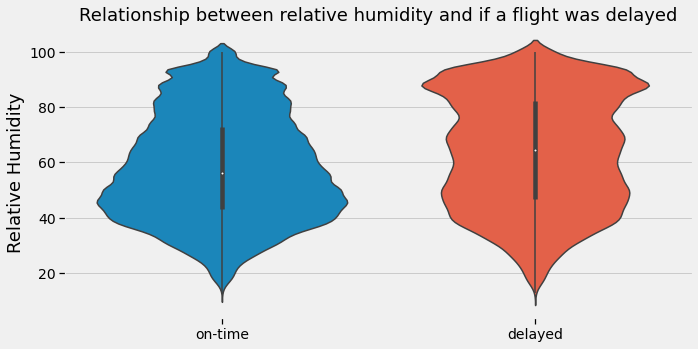

In [34]:
# Write your code here
df_temp = data_eda.copy()
df_temp['delayed'] = df_temp['delayed'].map(lambda val: 'delayed' if val == 1 else 'on-time')

plt.figure(figsize=(10, 5))
plt.title('Relationship between relative humidity and if a flight was delayed', fontsize=18)
ax = sns.violinplot(x='delayed', y='humid', data=df_temp)
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
ax.set_xlabel('', fontsize=18)
ax.set_ylabel('Relative Humidity', fontsize=18)
plt.show()

`'wind_speed'`

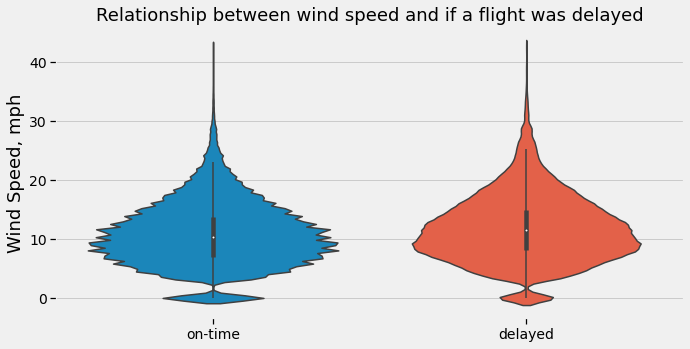

In [35]:
# Write your code here
df_temp = data_eda.copy()
df_temp['delayed'] = df_temp['delayed'].map(lambda val: 'delayed' if val == 1 else 'on-time')

plt.figure(figsize=(10, 5))
plt.title('Relationship between wind speed and if a flight was delayed', fontsize=18)
ax = sns.violinplot(x='delayed', y='wind_speed', data=df_temp)
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
ax.set_xlabel('', fontsize=18)
ax.set_ylabel('Wind Speed, mph', fontsize=18)
plt.show()

`'wind_dir'`

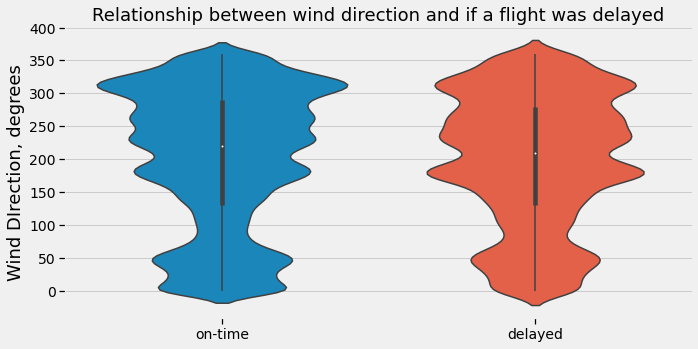

In [36]:
# Write your code here
df_temp = data_eda.copy()
df_temp['delayed'] = df_temp['delayed'].map(lambda val: 'delayed' if val == 1 else 'on-time')

plt.figure(figsize=(10, 5))
plt.title('Relationship between wind direction and if a flight was delayed', fontsize=18)
ax = sns.violinplot(x='delayed', y='wind_dir', data=df_temp)
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
ax.set_xlabel('', fontsize=18)
ax.set_ylabel('Wind DIrection, degrees', fontsize=18)
plt.show()

`'pressure'`

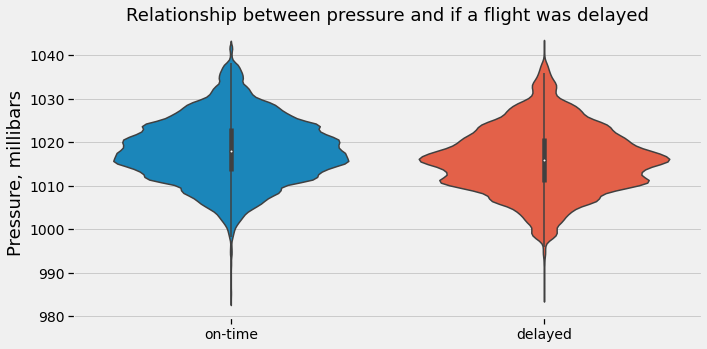

In [37]:
# Write your code here
df_temp = data_eda.copy()
df_temp['delayed'] = df_temp['delayed'].map(lambda val: 'delayed' if val == 1 else 'on-time')

plt.figure(figsize=(10, 5))
plt.title('Relationship between pressure and if a flight was delayed', fontsize=18)
ax = sns.violinplot(x='delayed', y='pressure', data=df_temp)
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
ax.set_xlabel('', fontsize=18)
ax.set_ylabel('Pressure, millibars', fontsize=18)
plt.show()

`'precip'`

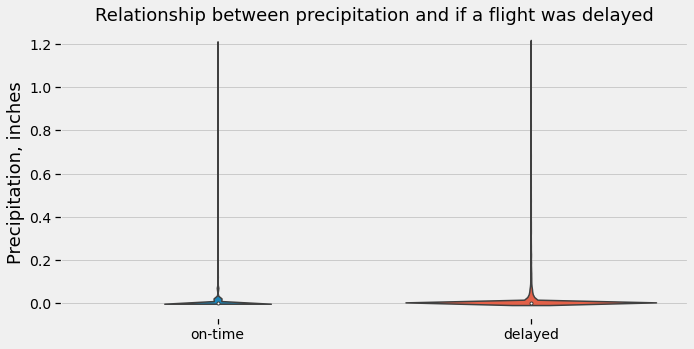

In [38]:
# Write your code here
df_temp = data_eda.copy()
df_temp['delayed'] = df_temp['delayed'].map(lambda val: 'delayed' if val == 1 else 'on-time')

plt.figure(figsize=(10, 5))
plt.title('Relationship between precipitation and if a flight was delayed', fontsize=18)
ax = sns.violinplot(x='delayed', y='precip', data=df_temp)
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
ax.set_xlabel('', fontsize=18)
ax.set_ylabel('Precipitation, inches', fontsize=18)
plt.show()

`'visib'`

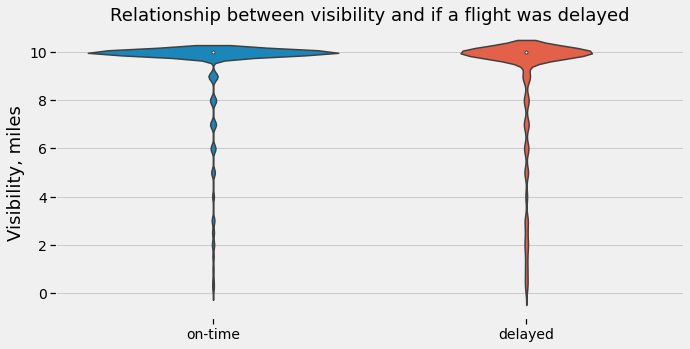

In [39]:
# Write your code here
df_temp = data_eda.copy()
df_temp['delayed'] = df_temp['delayed'].map(lambda val: 'delayed' if val == 1 else 'on-time')

plt.figure(figsize=(10, 5))
plt.title('Relationship between visibility and if a flight was delayed', fontsize=18)
ax = sns.violinplot(x='delayed', y='visib', data=df_temp)
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
ax.set_xlabel('', fontsize=18)
ax.set_ylabel('Visibility, miles', fontsize=18)
plt.show()

Lastly, because `'wind_dir'` is an angular measurement, let's look use an angular histogram (rose diagram) to visualize.

In [40]:
!pip install windrose

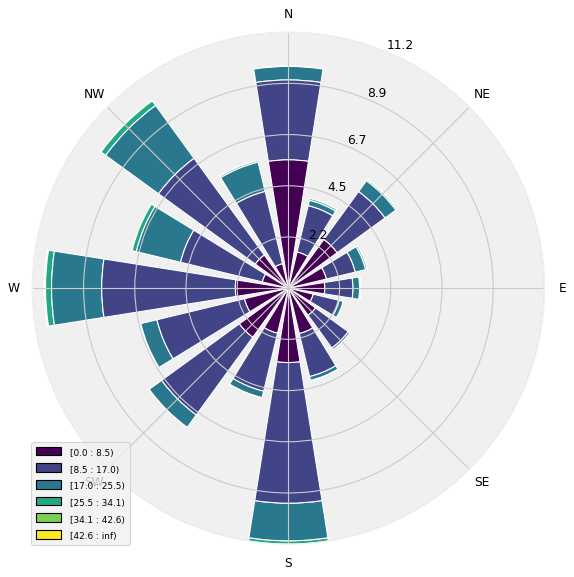

In [41]:
from windrose import WindroseAxes
import matplotlib.cm as cm
ax = WindroseAxes.from_ax()
ax.bar(data_eda['wind_dir'], data_eda['wind_speed'], normed=True, 
       opening=0.8, edgecolor='white', cmap=cm.viridis)
ax.set_legend()
ax.set_xticklabels(['E', 'NE',  'N', 'NW', 'W', 'SW','S', 'SE'])
plt.show()

## Training Label
Please explore the training label `'delayed'` and describe the level of balance using text and a figure. Also, please discuss how this would impact the development of a machine learning model, if at all.

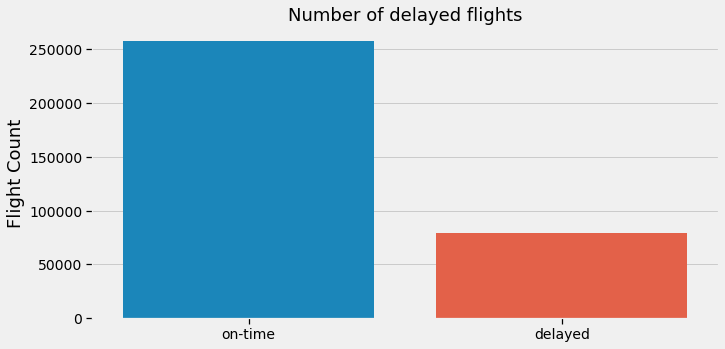

In [42]:
# Write your code here
df_temp = data_eda.copy()
df_temp['delayed'] = df_temp['delayed'].map(lambda val: 'delayed' if val == 1 else 'on-time')

plt.figure(figsize=(10, 5))
plt.title('Number of delayed flights', fontsize=18)
ax = sns.countplot(x='delayed', data=df_temp)
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
ax.set_xlabel('', fontsize=18)
ax.set_ylabel('Flight Count', fontsize=18)
plt.show()

In [43]:
# Write your code here
print('{:.2f}% of flights are delayed.'.format(sum(data_eda['delayed'] == 1) / 
                                               data_eda.shape[0] * 100))

23.47% of flights are delayed.


Explain your decision here, replacing this text.

**Answer:** *From the figure above, we can clearly see that the dataset is imbalanced and flights that are delayed (`'delayed' == 1`) are the minority class. To be exact, delayed flights make up 23% of all flights in our dataset. The fact that the dataset is imbalance is something we'll need to address during model development. It will impact how we split the data, the metrics we use to evaluate our model, and potentially our loss function and sampling techniques.*

# 3. Feature Engineering
In this section we will create some new features out of existing ones using simple data transformations. After this, we'll prepare two sets of features. `flight features`, which include only features about the flight (airline, departure time, etc.) and `flight and weather features`, which include the same features as `flight features` as well as additional weather features (humidity, temperature, etc.).

First, let's grab our preprocessed data again.

In [44]:
# Preprocess data for EDA
data_features = preprocess_data()

# View DataFrame
data_features.head(2)

,year,month,day,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,carrier,...,dewp,humid,wind_dir,wind_speed,wind_gust,precip,pressure,visib,delayed,delayed_group
0,2013,1,1,517.0,515,2.0,830.0,819,11.0,UA,...,28.04,64.43,260.0,12.65858,NaN,0.0,1011.9,10.0,0,on-time
1,2013,1,1,533.0,529,4.0,850.0,830,20.0,UA,...,24.98,54.81,250.0,14.96014,21.86482,0.0,1011.4,10.0,0,on-time


Next, let's address out missing data. Let's remind ourselves about what data is missing.

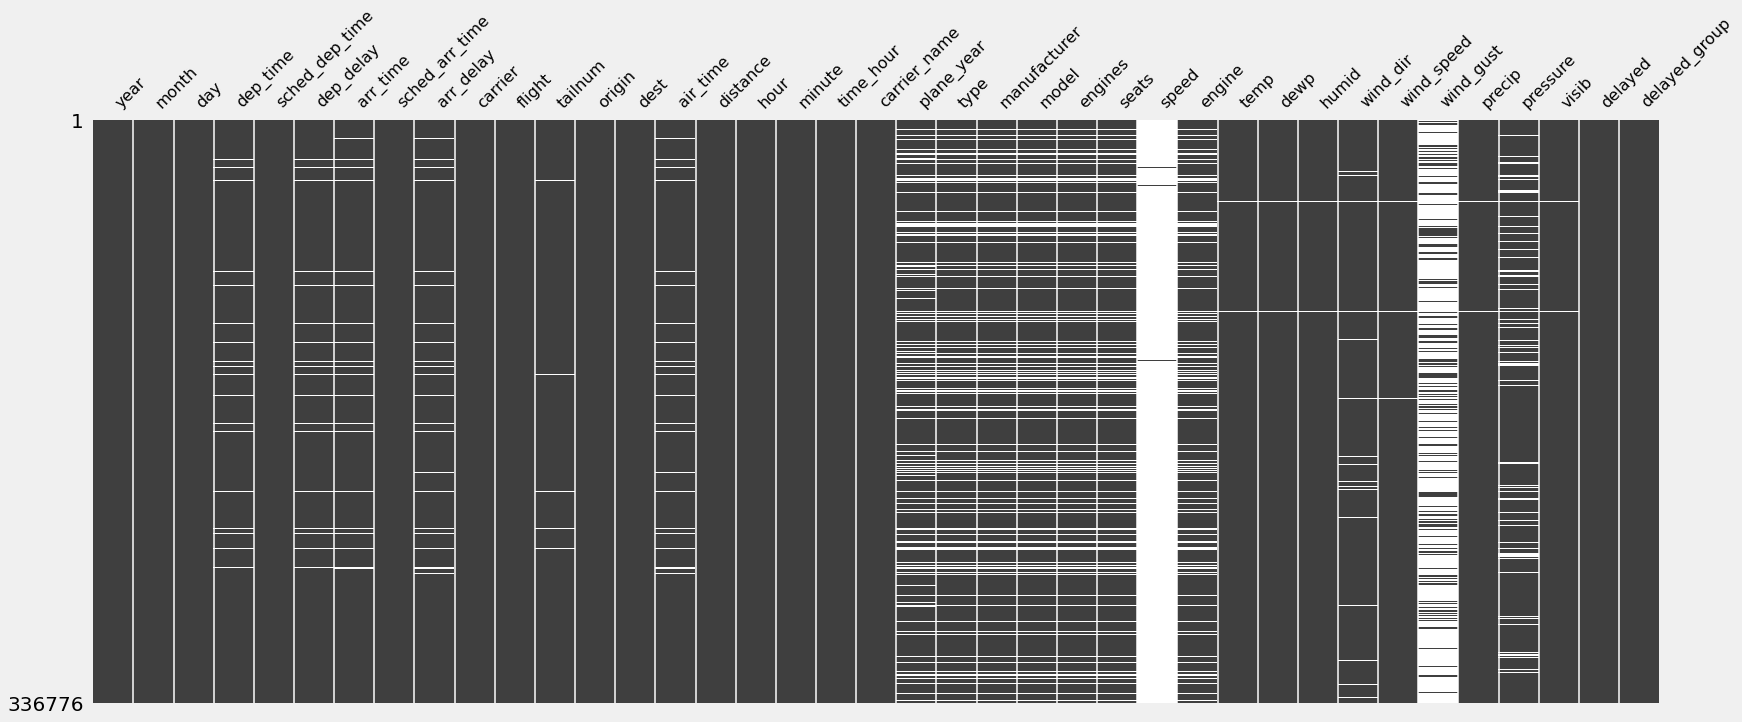

In [45]:
msno.matrix(data_features, sparkline=False);

First, we should drop the plane features that we are not planning to use at this point.

In [46]:
data_features = data_features.drop(columns=['plane_year', 'type', 'manufacturer', 'model', 
                                            'engines', 'seats', 'speed', 'engine'])

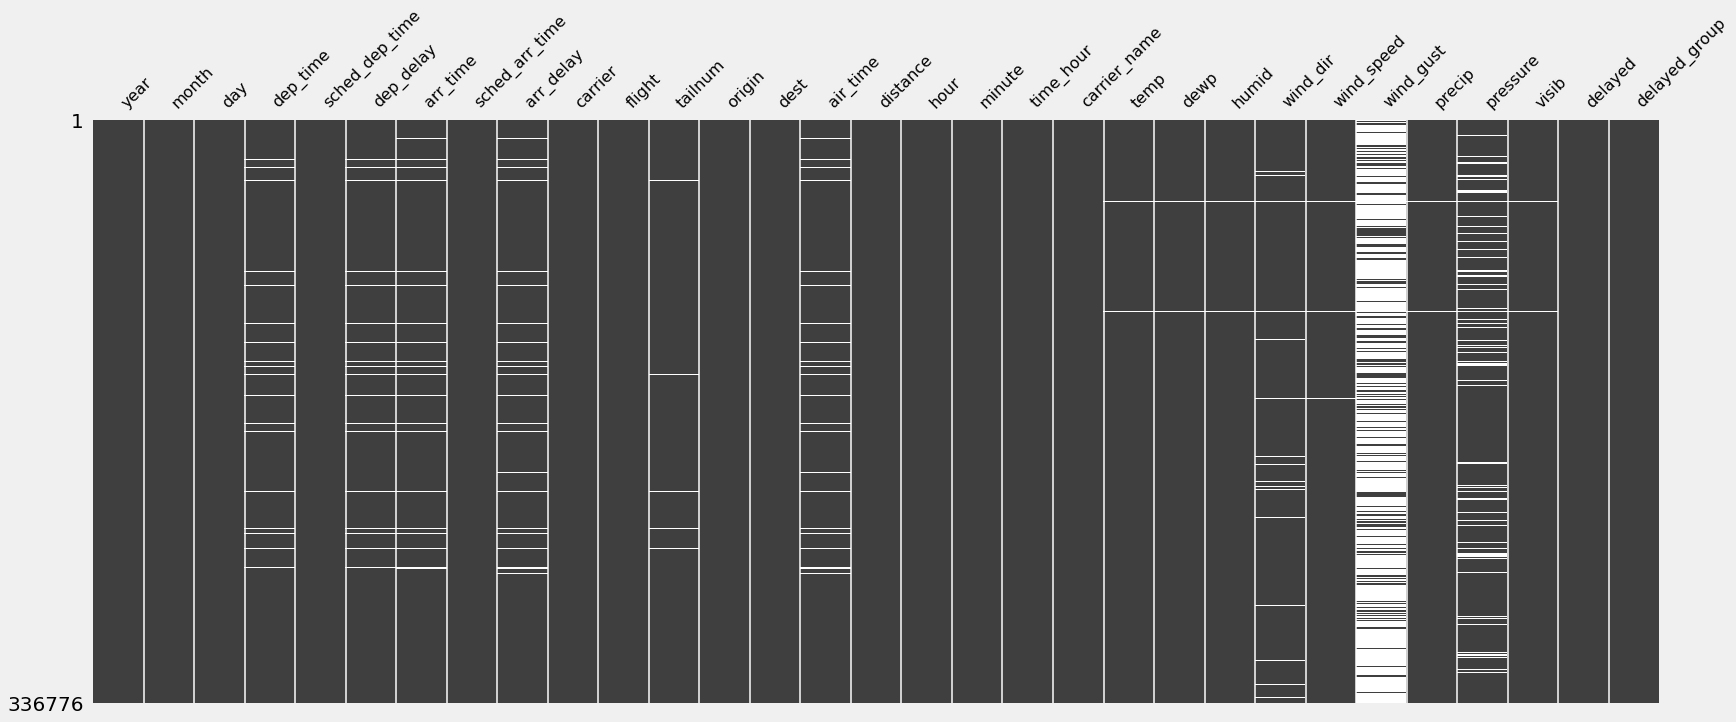

In [47]:
msno.matrix(data_features, sparkline=False);

With the exception of the `'wind_gust '` column, there are not many missing values. Next, we need to drop any row that has a missing value with the exception of the `'wind_gust '` column. We will be converting these missing values to `no gust` shortly.

In [48]:
data_features = \
    data_features[~data_features.loc[:, data_features.columns != 'wind_gust'].isna().any(axis=1).values]

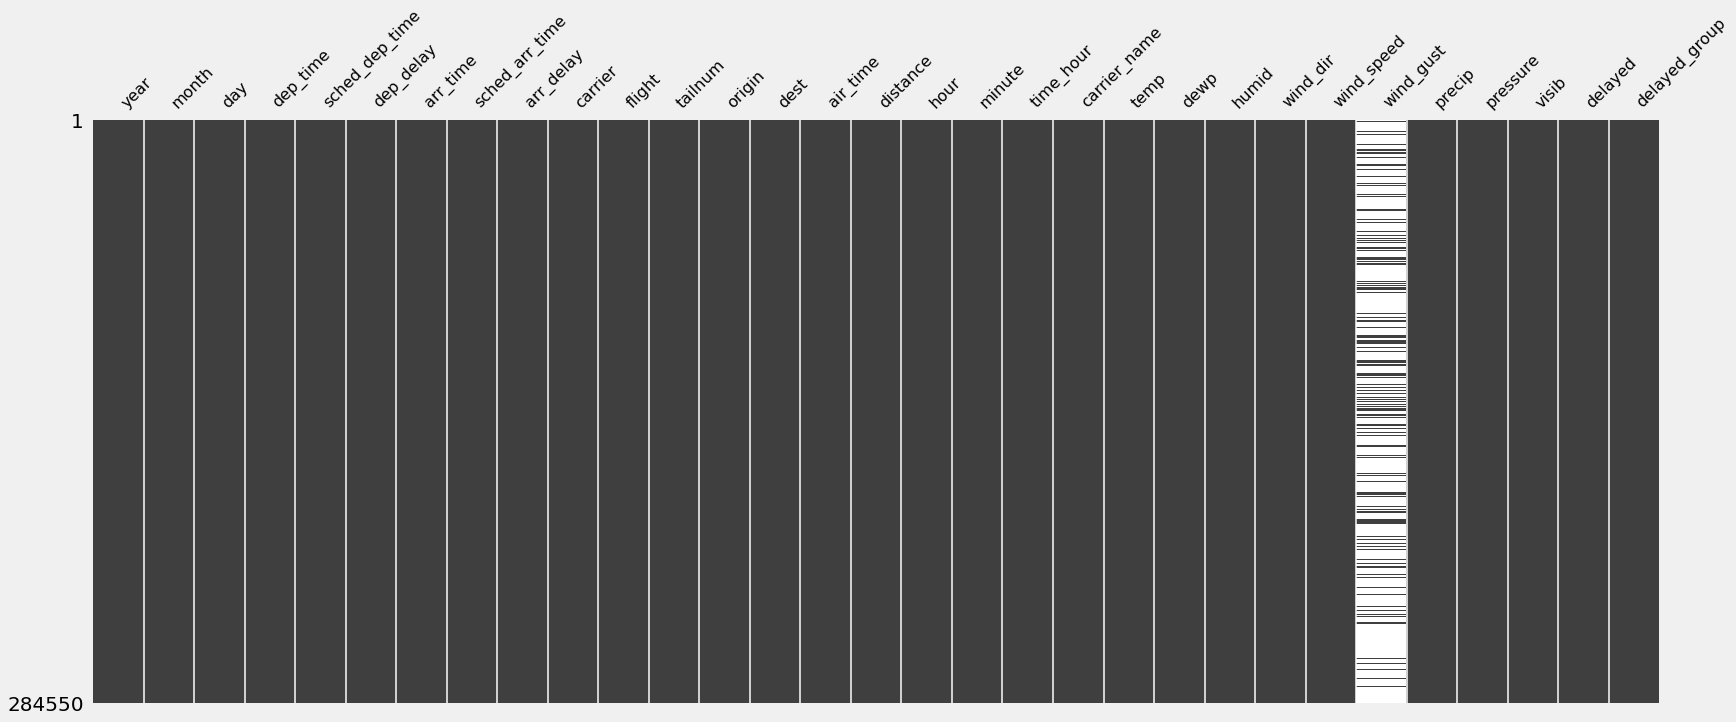

In [49]:
msno.matrix(data_features, sparkline=False);

Looking much better.

Because we are going to look at the data in detail in order to define features, it's best to split the data into training and test sets now, then only inspect the training set. Remember what we learned in Lecture 21 about a form a data leakage called train/test contamination. Do not touch your test dataset until your final model is trained.

You'll notice that we've added an argument for `'stratify'` and set it equal to our training target `'delayed'`. This is done because the data is imbalanced as we discussed previously. If 20% of the flights are delayed in the dataset, then we want 20% of the flights in the train and test datasets to be also be delayed.

In [50]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data_features, train_size=0.8, 
                               test_size=0.2, random_state=0, stratify=data_features['delayed'])
print('Train:', train.shape, 'Test:', test.shape)
print('Train delays proportion: {:.2f} %'.format(train['delayed'][train['delayed'] == 1].shape[0] / train.shape[0] * 100))
print('Test delays proportion: {:.2f} %'.format(test['delayed'][test['delayed'] == 1].shape[0] / test.shape[0] * 100))

Train: (227640, 31) Test: (56910, 31)
Train delays proportion: 20.11 %
Test delays proportion: 20.11 %


Let's create some features!

## Question 3a
Our first engineered feature will be `'wind_cardinal_dir'`, which will be engineered from `'wind_dir'`. Create a functioned called `get_cardinal_direction()`, which takes an a value for `'wind_dir'` and returns one of 8 cardinal directions `['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW']`. 

For example,
```python
get_cardinal_direction(angle=12)

>>> 'N'

get_cardinal_direction(angle=60)

>>> 'NE'

get_cardinal_direction(angle=270)

>>> 'W'

get_cardinal_direction(angle=181)

>>> 'S'

get_cardinal_direction(angle=45)

>>> 'NE'
```
Here is the earlier figure for your reference.

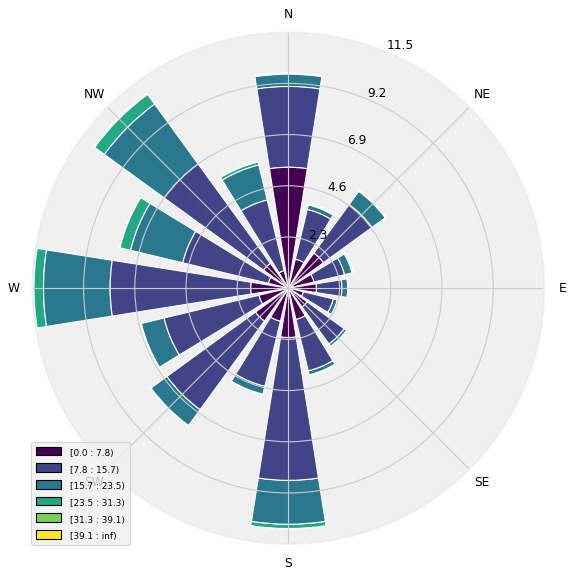

In [51]:
ax = WindroseAxes.from_ax()
ax.bar(train['wind_dir'], train['wind_speed'], normed=True, 
       opening=0.8, edgecolor='white', cmap=cm.viridis)
ax.set_legend()
ax.set_xticklabels(['E', 'NE',  'N', 'NW', 'W', 'SW','S', 'SE'])
plt.show()

In [52]:
def get_cardinal_direction(angle):
    
    # Write your code here
    cardinal_directions = ['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW']    
    ix = round(angle / (360. / len(cardinal_directions)))
    
    return cardinal_directions[ix % len(cardinal_directions)]

If you run the code below, you should get this:

`['NE', 'E', 'E', 'N', 'W', 'S', 'NE', 'NE', 'N']`

In [53]:
[get_cardinal_direction(angle) for angle in [23.4, 79.4, 100., 0.1, 265.2, 183, 64.5, 32.9, 10.]]

['NE', 'E', 'E', 'N', 'W', 'S', 'NE', 'NE', 'N']

Next, for a quick sanity check, create a bar chart where the x-axis is the orientation category and the y-axis is the count. Compare this to the rose diagram above to ensure the same distribution is expressed. 

Hint: `sns.countplot()`

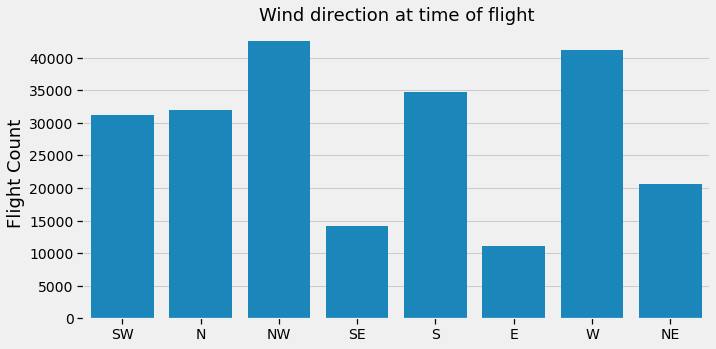

In [54]:
# Here I've created a temporary DataFrame using your function. Plot df_temp['wind_dir'].
df_temp = pd.DataFrame()
df_temp['wind_dir'] = train['wind_dir'].map(lambda val: get_cardinal_direction(val))

# Write your code here
plt.figure(figsize=(10, 5))
plt.title('Wind direction at time of flight', fontsize=18)
ax = sns.countplot(x='wind_dir', data=df_temp, color='#008fd5')
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
ax.set_xlabel('', fontsize=18)
ax.set_ylabel('Flight Count', fontsize=18)
plt.show()

Next, we need to create a function to generate our desired feature in categorical format for all `'wind_dir'`s, not just one.

In [55]:
def add_wind_cardinal_dir_feature(data):
    
    """
    Returns a feature for the wind cardinal directions.

    Parameters:
        data (DataFrame): A DataFrame with the column 'wind_dir'.

    Returns:
        categoricals (DataFrame): A DataFrame with the wind cardinal direction features.   
    """

    categoricals = pd.get_dummies(data['wind_dir'].map(lambda val: get_cardinal_direction(val)), 
                                  prefix='wind_dir', drop_first=True)
    
    return categoricals

Let's test our function out on the training dataset.

In [56]:
add_wind_cardinal_dir_feature(train).head()

,wind_dir_N,wind_dir_NE,wind_dir_NW,wind_dir_S,wind_dir_SE,wind_dir_SW,wind_dir_W
29602,0,0,0,0,0,1,0
20272,1,0,0,0,0,0,0
20351,0,0,1,0,0,0,0
321600,0,0,1,0,0,0,0
191206,0,0,0,0,1,0,0


## Question 3b
Let's tackle the `'wind_gust'` feature next. You'll recall that we determined that `'wind_gust'` == NaN when a gust is not registered. Create a function called `add_wind_gust_feature()` that converts the original `'wind_gust'` column into a binary value. `'wind_gust'` = 1 when there is a gust and `'wind_gust'` = 0 when there is no gust. `add_wind_gust_feature()` should return a DataFrame with one column called `'wind_gust'`.

In [57]:
def add_wind_gust_feature(data):
    
    """
    Returns a binary feature (Wind Gust or No Wind Gust).

    Parameters:
        data (DataFrame): a DataFrame with column 'wind_gust'.
        
    Returns:
        wind_gust (DataFrame): A DataFrame with the binary wind gust feature.   
    """
    
    # Write your code here
    wind_gust = data['wind_gust'].map(lambda val: 0 if np.isnan(val) else 1).to_frame()
    
    return wind_gust

Let's test our function out on the training dataset.

In [58]:
add_wind_gust_feature(train).head()

,wind_gust
29602,0
20272,1
20351,0
321600,1
191206,1


## Question 3c
In the previous assignment (Assignment 7), we encoded the hour of the day and day of the week using dummy encoding. 

Let's create some sample data to remind ourselves.

In [59]:
day_of_the_week = pd.DataFrame(data=['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun'], 
                               columns=['Day_of_the_week'])
day_of_the_week

,Day_of_the_week
0,Mon
1,Tues
2,Wed
3,Thurs
4,Fri
5,Sat
6,Sun


Dummy encoding for the day of the week would look something like this.

In [60]:
pd.get_dummies(day_of_the_week, prefix='', prefix_sep='', drop_first=True)

,Mon,Sat,Sun,Thurs,Tues,Wed
0,1,0,0,0,0,0
1,0,0,0,0,1,0
2,0,0,0,0,0,1
3,0,0,0,1,0,0
4,0,0,0,0,0,0
5,0,1,0,0,0,0
6,0,0,1,0,0,0


You'll remember that we set `drop_first=True`, which is why there is no Friday column.

By using dummy encoding, we have turned one feature intro 6. Now, imagine if we were to do the same thing for `Month`, `day`, and `hour`.

- `Month` x (12-1)
- `Day`   x (31-1)
- `Hour`  x (24-1)

Thats another 64 features, which is not ideal (curse of dimensionality). 

You may then think, Ok, what about leaving these are integers.

- `Month` - [0, 1, 2, ..., 11]
- `Day`   - [0, 1, 2, ..., 30]
- `Hour`  - [0, 1, 2, ..., 23]

That could work, but 1 am (integer = 0) and midnight (integer = 23) are very similart times of the day, but they are very far apart in integer space, which creates a discontinuity and may confuse the model.

So, let's try another method, which we'll call cyclical encoding. Time data is cyclical in nature. One hour has 60 minutes and one day has 24 hours. When an hour completes, the next one starts counting minutes from zero. This means that the 1st and 2nd minute of an hour strongly correlated, but it also means that the 59th and 1st minute are correlated as well.

To clearly illustrate this point, let's look at the Uber data from Lecture 10.

In [61]:
uber_data = pd.read_csv('uber-raw-data-jun14.csv', nrows = 20000)
uber_data['Date/Time'] = pd.to_datetime(uber_data['Date/Time'])
uber_data['Hour'] = uber_data['Date/Time'].dt.hour
uber_data['Day'] = uber_data['Date/Time'].dt.dayofweek
uber_data.head()

,Date/Time,Lat,Lon,Base,Hour,Day
0,2014-06-01 00:00:00,40.7293,-73.9920,B02512,0,6
1,2014-06-01 00:01:00,40.7131,-74.0097,B02512,0,6
2,2014-06-01 00:04:00,40.3461,-74.6610,B02512,0,6
3,2014-06-01 00:04:00,40.7555,-73.9833,B02512,0,6
4,2014-06-01 00:07:00,40.6880,-74.1831,B02512,0,6


Hour of the day.

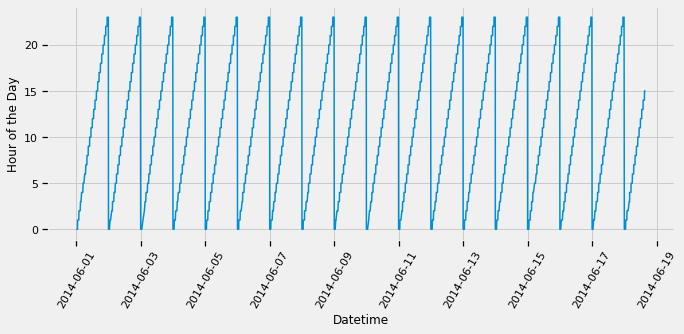

In [62]:
plt.figure(figsize=(10, 4))
plt.plot(uber_data['Date/Time'], uber_data['Hour'])
plt.xlabel('Datetime')
plt.ylabel('Hour of the Day')
plt.xticks(rotation=60)
plt.show()

Day of the week.

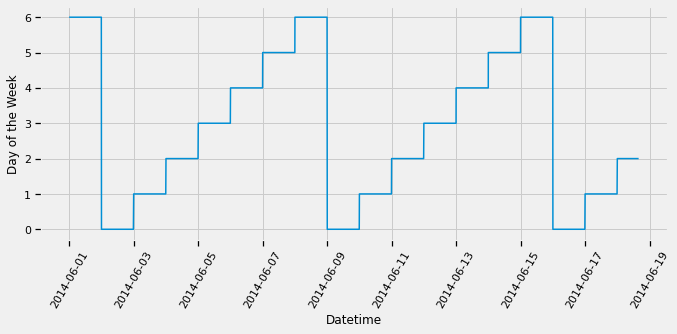

In [63]:
plt.figure(figsize=(10, 4))
plt.plot(uber_data['Date/Time'], uber_data['Day'])
plt.xlabel('Datetime')
plt.ylabel('Day of the Week')
plt.xticks(rotation=60)
plt.show()

Hopefully this is clear. Now, let's look into how we can use cyclical encoding for our time features. For this, we'll use a `sine` and `cosine` transformation. Here are the formulas we'll use.

In [64]:
def sine(time, max_time):
    """
    Returns the sine transformation for a time.

    Parameters:
        time (int): A time value (hour, day, month, etc.).
        max_time (int): The maximum time for the cycle (hour=24, month=12, day of week=7).
        
    Returns:
        float: The sine transformation for a time.   
    """
    return np.sin((2 * np.pi * time) / max_time)

def cosine(time, max_time):
    """
    Returns the cosine transformation for a time.

    Parameters:
        time (int): A time value (hour, day, month, etc.).
        max_time (int): The maximum time for the cycle (hour=24, month=12, day of week=7).
        
    Returns:
        float: The cosine transformation for a time.   
    """
    return np.cos((2 * np.pi * time) / max_time)

Below, you can see a nice [animation](https://www.math.hkust.edu.hk/~machiang/1013/Notes/tri_func.html) of the cyclical nature of the `sine` and `cosine` transformations.
<br>
<img src="images/sine.gif" alt="drawing" width="700"/>
<br>
<br>
<img src="images/cosine.gif" alt="drawing" width="700"/>
<br>
But why do we need two variables to encode time? If we only use the `sine` encoding we would still have an issue, as two separate timestamps will have the same `sine` encoding within one cycle, as the graph is symmetrical around the turning points. This is why we also perform the `cosine` transformation, which has a 90$^{o}$ phase offset from `sine`.

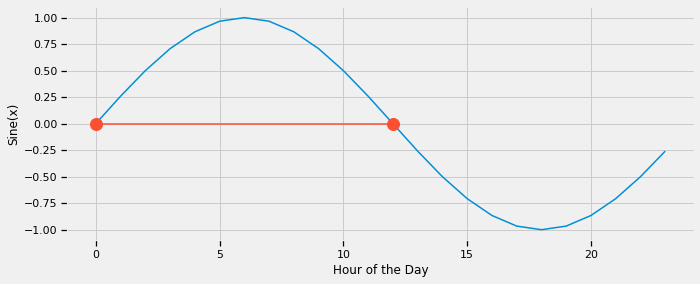

In [65]:
time = [x for x in range(24)]
sin_disp = [sine(x, 24) for x in time]
plt.figure(figsize=(10, 4))
plt.plot(time, sin_disp)
plt.plot([0, 12], [0, 0], '-o', ms=12)
plt.xlabel('Hour of the Day')
plt.ylabel('Sine(x)')
plt.show()

So, what does this look like for the uber data?

In [66]:
uber_data[['hour_sin', 'hour_cos']] = \
    uber_data['Date/Time'].apply(lambda dt: pd.Series({'hour_sin': sine(dt.hour, 24),
                                                       'hour_cos': cosine(dt.hour, 24)}))
uber_data.head()

,Date/Time,Lat,Lon,Base,Hour,Day,hour_sin,hour_cos
0,2014-06-01 00:00:00,40.7293,-73.9920,B02512,0,6,0.0,1.0
1,2014-06-01 00:01:00,40.7131,-74.0097,B02512,0,6,0.0,1.0
2,2014-06-01 00:04:00,40.3461,-74.6610,B02512,0,6,0.0,1.0
3,2014-06-01 00:04:00,40.7555,-73.9833,B02512,0,6,0.0,1.0
4,2014-06-01 00:07:00,40.6880,-74.1831,B02512,0,6,0.0,1.0


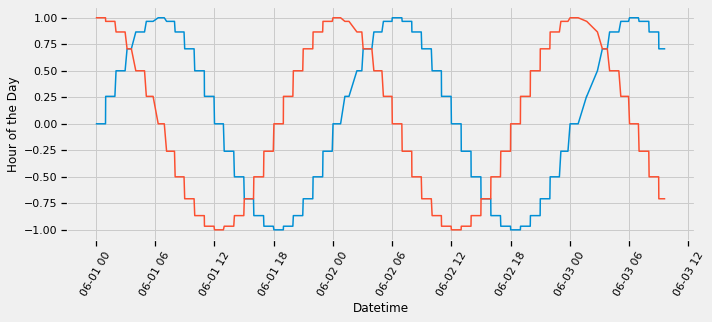

In [67]:
plt.figure(figsize=(10, 4))
plt.plot(uber_data['Date/Time'].iloc[0:2000], uber_data['hour_sin'].iloc[0:2000])
plt.plot(uber_data['Date/Time'].iloc[0:2000], uber_data['hour_cos'].iloc[0:2000])
plt.xlabel('Datetime')
plt.ylabel('Hour of the Day')
plt.xticks(rotation=60)
plt.show()

Lastly, let's visualize the new 2-dimensional transformed feature vector with a scatterplot. 

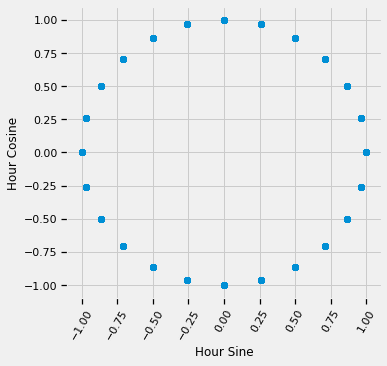

In [68]:
plt.figure(figsize=(5, 5))
plt.plot(uber_data['hour_sin'], uber_data['hour_cos'], 'o')
plt.xlabel('Hour Sine')
plt.ylabel('Hour Cosine')
plt.xticks(rotation=60)
plt.show()

Ok, that was quite the tangent but its important to understand that there are many ways of encoding features and some are more appropriate than others.

In this question, you need to create a function called `add_time_feature(data, method)` which takes a DataFrame (`train`, `test`, etc.) and returns a DataFrame of time features for `month`, `day of week` and `hour`. The second argument indicates which type of encoding to use: `'integer', 'dummy', 'cyclical'`. Dummy encoding should set `drop_first=True`. Lastly, for the integer encoding, which is the form the data is in to being with, you much scale `month`, `day of week` and `hour` to values between `0` and `1`. For example, January should be `0` and December should be `1`.

In [69]:
def add_time_feature(data, method):
    
    """
    Returns a DataFrame with encoded features for month, day of week and hour.

    Parameters:
        data (DataFrame): A DataFrame with columns 'time_hour', 'month', and 'hour'.
        method (string): A string indicating which encoding method to use ('integer', 'dummy', 'cyclical').
        
    Returns:
       DataFrame: A DataFrame with encoded features for month, day of week and hour.
    """
    
    # Copy data
    df = data.copy()
    
    # Let's add the day of the week feature
    df['day_of_week'] = df['time_hour'].dt.dayofweek
    
    if method == 'integer':
        df_temp = df[['month', 'day_of_week', 'hour']]
        df_temp['month'] = df_temp['month'] / 11.
        df_temp['day_of_week'] = df_temp['day_of_week'] / 6.
        df_temp['hour'] = df_temp['hour'] / 23.
        return df_temp
    
    elif method == 'dummy':
        cat_features = ['month', 'day_of_week', 'hour']
        categoricals = [pd.get_dummies(df[s], prefix=s, drop_first=True) for s in cat_features]
        return pd.concat(categoricals, axis=1)
    
    # Write your code here
    elif method == 'cyclical':
        df_temp = pd.DataFrame(index=df.index)
        df_temp['month_sin'] = df['month'].map(lambda dt: sine(dt, 12)).values
        df_temp['month_cos'] = df['month'].map(lambda dt: cosine(dt, 12)).values
        df_temp['day_of_week_sin'] = df['day_of_week'].map(lambda dt: sine(dt, 7)).values
        df_temp['day_of_week_cos'] = df['day_of_week'].map(lambda dt: cosine(dt, 7)).values
        df_temp['hour_sin'] = df['hour'].map(lambda dt: sine(dt, 24)).values
        df_temp['hour_cos'] = df['hour'].map(lambda dt: cosine(dt, 24)).values
        return df_temp
    
    else:
        return None

Let's test our function.

for `add_time_feature(data=train, method='integer')`, you should get shape `(199185, 3)`.

In [70]:
print('Shape: {}'.format(add_time_feature(data=train, method='integer').shape))
add_time_feature(data=train, method='integer').head()

Shape: (227640, 3)


,month,day_of_week,hour
29602,0.909091,0.500000,0.652174
20272,0.090909,0.500000,0.391304
20351,0.090909,0.500000,0.478261
321600,0.818182,0.833333,0.652174
191206,0.363636,1.000000,0.739130


for `add_time_feature(data=train, method='dummy')`, you should get shape `(199185, 35)`.

In [71]:
print('Shape: {}'.format(add_time_feature(data=train, method='dummy').shape))
add_time_feature(data=train, method='dummy').head()

Shape: (227640, 35)


,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
29602,0,0,0,0,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
20272,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20351,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
321600,0,0,0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
191206,0,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


for `add_time_feature(data=train, method='cyclical')`, you should get shape `(199185, 6)`.

In [72]:
print('Shape: {}'.format(add_time_feature(data=train, method='cyclical').shape))
add_time_feature(data=train, method='cyclical').head()

Shape: (227640, 6)


,month_sin,month_cos,day_of_week_sin,day_of_week_cos,hour_sin,hour_cos
29602,-0.866025,5.000000e-01,0.433884,-0.900969,-0.707107,-0.707107
20272,0.500000,8.660254e-01,0.433884,-0.900969,0.707107,-0.707107
20351,0.500000,8.660254e-01,0.433884,-0.900969,0.258819,-0.965926
321600,-1.000000,-1.836970e-16,-0.974928,-0.222521,-0.707107,-0.707107
191206,0.866025,-5.000000e-01,-0.781831,0.623490,-0.965926,-0.258819


Next, let's create a function called `create_features()`, which takes a DataFrame as input and outputs a DataFrame features for training. Quantitative features are converted to standard units using `StandardScaler`, while categorical features are converted to dummy variables using `pd.get_dummies`.

Let's create two lists including the flight and weather features to include.

In [73]:
# Flight features
flight_features = ['month', 'hour', 'day_of_week', 'carrier_name', 'distance', 'arr_delay']

# Flight features + weather features
flight_weather_features = flight_features + ['temp', 'dewp', 'humid', 'wind_dir', 'wind_speed', 
                                             'wind_gust', 'precip', 'pressure', 'visib']

Next, let's list the numerical features that need to be scaled and the categorical features than need dummy encoding.

In [74]:
# Define numerical features to be scaled
num_features = ['distance', 'temp', 'dewp', 'humid', 'wind_speed', 'precip', 'pressure', 'visib', 'arr_delay']

# Define categorical features to be dummy encoded
cat_features = ['carrier_name']

In [75]:
from sklearn.preprocessing import StandardScaler

def create_features(df, return_features, cat_features, num_features, time_encoding):
    
    """
    Returns a DataFrame with encoded features for month, day of week and hour.

    Parameters:
        data (DataFrame): A DataFrame with columns 'time_hour', 'month', and 'hour'.
        method (string): A string indicating which encoding method to use ('integer', 'dummy', 'cyclical').
        
    Returns:
       DataFrame: A DataFrame with encoded features for month, day of week and hour.
    """
    
    # Create an empty list for your features
    features = list()
    
    # Add cardinal wind direction feature
    features.append(add_wind_cardinal_dir_feature(df))
    
    # Add wind gust feature
    features.append(add_wind_gust_feature(df))   
    
    # Add time features
    features.append(add_time_feature(df, method=time_encoding))
    
    # Add cat_features using dummy encoding
    features += [pd.get_dummies(df[s], prefix=s, drop_first=True) for s in cat_features]
    
    # Scale numerical features using standardization
    scaled = df[num_features].copy()
    scaler = StandardScaler()
    scaler.fit(scaled)
    scaled.iloc[:, :] = scaler.transform(scaled) 
    
     # Add num_features
    features.append(scaled)
    
    # Concatentate the DataFrames in the features list
    features = pd.concat(features, axis=1)
    
    return features

Let's check out our function for the `train` dataset using `flight_weather_features` and `'integer'` encoding for time.

In [76]:
create_features(train, return_features=flight_weather_features, cat_features=cat_features, 
                num_features=num_features, time_encoding='integer').head()

,wind_dir_N,wind_dir_NE,wind_dir_NW,wind_dir_S,wind_dir_SE,wind_dir_SW,wind_dir_W,wind_gust,month,day_of_week,...,carrier_name_Virgin America,distance,temp,dewp,humid,wind_speed,precip,pressure,visib,arr_delay
29602,0,0,0,0,0,1,0,0,0.909091,0.500000,...,0,-0.148648,1.283192,0.400865,-1.314558,-1.398039,-0.107715,-0.049184,0.284163,0.172340
20272,1,0,0,0,0,0,0,1,0.090909,0.500000,...,0,-0.419064,-2.155404,-1.917318,-0.270743,0.704484,-0.107715,0.772567,0.284163,0.100828
20351,0,0,1,0,0,0,0,0,0.090909,0.500000,...,0,-1.171881,-1.985966,-2.121318,-1.041271,1.124988,-0.107715,0.745625,0.284163,0.839781
321600,0,0,1,0,0,0,0,1,0.818182,0.833333,...,0,-0.067116,0.445969,0.298865,-0.328394,0.073727,-0.107715,-0.224312,0.284163,-0.614288
191206,0,0,0,0,1,0,0,1,0.363636,1.000000,...,0,-0.703069,0.336332,-0.424408,-1.389948,-0.136525,-0.107715,0.691739,0.284163,-0.018358


And, let's do the same thing for our test data.

In [77]:
create_features(test, return_features=flight_weather_features, cat_features=cat_features, 
                num_features=num_features, time_encoding='integer').head()

,wind_dir_N,wind_dir_NE,wind_dir_NW,wind_dir_S,wind_dir_SE,wind_dir_SW,wind_dir_W,wind_gust,month,day_of_week,...,carrier_name_Virgin America,distance,temp,dewp,humid,wind_speed,precip,pressure,visib,arr_delay
316411,1,0,0,0,0,0,0,0,0.818182,0.000000,...,0,-0.458104,0.054178,0.238113,0.312134,-0.346940,-0.107828,0.793394,0.283227,-0.609989
216496,0,0,1,0,0,0,0,1,0.454545,0.833333,...,0,-1.150894,-0.055038,-0.168460,-0.408409,3.046870,-0.107828,-0.475046,0.283227,0.933649
204530,0,0,0,0,0,0,1,0,0.454545,0.000000,...,0,-0.134079,-0.442255,-0.685917,-0.782004,-0.134827,-0.107828,-0.232153,0.283227,0.458684
108870,0,0,0,1,0,0,0,0,1.090909,1.000000,...,0,-0.553006,-0.601113,-0.685917,-0.513882,-0.559053,-0.107828,-0.218659,0.283227,-0.301261
245823,0,0,0,0,0,0,1,0,0.545455,0.333333,...,0,-1.138692,1.047042,1.263788,0.692390,-0.134827,-0.107828,-0.974326,0.283227,-0.301261


Everything looks good, right? Not so quickly. Remember this figure from the lecture?

<br>
<img src="images/Scaling.png" alt="drawing" width="600"/>
<br>

## Question 3d
The mistake we make in the `create_features()` function is that we scale the numerical data using the mean and standard deviation from whatever dataset we pass to the function. However, as you can see from the figure above, we want to always get our scaling parameters from the **TRAINING** dataset. In the cell below, please explain why this is the case.

*Replace this test with your answer.*

Ok, so let's update our function definition for `create_features()` and remove the scaling code.

In [78]:
from sklearn.preprocessing import StandardScaler

def create_features(df, return_features, cat_features, num_features, time_encoding):
    
    """
    Returns a DataFrame with encoded features for month, day of week and hour.

    Parameters:
        data (DataFrame): A DataFrame with columns 'time_hour', 'month', and 'hour'.
        method (string): A string indicating which encoding method to use ('integer', 'dummy', 'cyclical').
        
    Returns:
       DataFrame: A DataFrame with encoded features for month, day of week and hour.
    """
    
    # Create an empty list for your features
    features = list()
    
    # Add cardinal wind direction feature
    features.append(add_wind_cardinal_dir_feature(df))

    # Add wind gust feature
    features.append(add_wind_gust_feature(df))   
    
    # Add time features
    features.append(add_time_feature(df, method=time_encoding))
    
    # Add cat_features using dummy encoding
    features += [pd.get_dummies(df[s], prefix=s, drop_first=True) for s in cat_features]
    
     # Add num_features
    features.append(df[num_features])
    
    # Concatentate the DataFrames in the features list
    features = pd.concat(features, axis=1)
    
    return features

In [79]:
create_features(train, return_features=flight_weather_features, cat_features=cat_features, 
                num_features=num_features, time_encoding='integer').head(2)

,wind_dir_N,wind_dir_NE,wind_dir_NW,wind_dir_S,wind_dir_SE,wind_dir_SW,wind_dir_W,wind_gust,month,day_of_week,...,carrier_name_Virgin America,distance,temp,dewp,humid,wind_speed,precip,pressure,visib,arr_delay
29602,0,0,0,0,0,1,0,0,0.909091,0.5,...,0,937,80.06,48.02,32.53,3.45234,0.0,1017.5,10.0,12.0
20272,1,0,0,0,0,0,0,1,0.090909,0.5,...,0,738,17.96,3.02,51.36,14.96014,0.0,1023.6,10.0,9.0


Well, looks like we need to address this issue. Let's create a new function called `create_trian_test_features()` that takes both `train` and `test` as input and scales `test` using the mean and stanard deviation from `train`.

In [80]:
def create_trian_test_features(train, test, return_features, cat_features, 
                               num_features, time_encoding):
    
    """
    Returns a DataFrame with encoded features for month, day of week and hour.

    Parameters:
        data (DataFrame): A DataFrame with columns 'time_hour', 'month', and 'hour'.
        method (string): A string indicating which encoding method to use ('integer', 'dummy', 'cyclical').
        
    Returns:
       DataFrame: A DataFrame with encoded features for month, day of week and hour.
    """
    
    # Get training features
    train_features = create_features(train, flight_weather_features, cat_features, 
                                     num_features, time_encoding)
    
    # Scale numeric training features using standardization
    scaler = StandardScaler()
    scaler.fit(train_features[num_features])
    train_features.loc[:, num_features] = scaler.transform(train_features[num_features])
    
    # Select the requested features from train
    train_features = train_features[[col for col in train_features.columns 
                                     if any(feat in col for feat in return_features)]]
    
    # Get test features and scale them
    if test is not None:
        test_features = create_features(test, flight_weather_features, cat_features, 
                                        num_features, time_encoding)
        test_features.loc[:, num_features] = scaler.transform(test_features[num_features])
        test_features = test_features[[col for col in test_features.columns 
                                       if any(feat in col for feat in return_features)]]
    else:
        test_features = None
    
    return {'train': train_features, 'test': test_features}

Test it out for `train`

In [81]:
create_trian_test_features(train, test, return_features=flight_weather_features, 
                           cat_features=cat_features, num_features=num_features, 
                           time_encoding='integer')['train'].head(2)

,wind_dir_N,wind_dir_NE,wind_dir_NW,wind_dir_S,wind_dir_SE,wind_dir_SW,wind_dir_W,wind_gust,month,day_of_week,...,carrier_name_Virgin America,distance,temp,dewp,humid,wind_speed,precip,pressure,visib,arr_delay
29602,0,0,0,0,0,1,0,0,0.909091,0.5,...,0,-0.148648,1.283192,0.400865,-1.314558,-1.398039,-0.107715,-0.049184,0.284163,0.172340
20272,1,0,0,0,0,0,0,1,0.090909,0.5,...,0,-0.419064,-2.155404,-1.917318,-0.270743,0.704484,-0.107715,0.772567,0.284163,0.100828


and `test`.

In [82]:
create_trian_test_features(train, test, return_features=flight_weather_features, 
                           cat_features=cat_features, num_features=num_features, 
                           time_encoding='integer')['test'].head(2)

,wind_dir_N,wind_dir_NE,wind_dir_NW,wind_dir_S,wind_dir_SE,wind_dir_SW,wind_dir_W,wind_gust,month,day_of_week,...,carrier_name_Virgin America,distance,temp,dewp,humid,wind_speed,precip,pressure,visib,arr_delay
316411,1,0,0,0,0,0,0,0,0.818182,0.000000,...,0,-0.455754,0.057258,0.243229,0.315190,-0.346778,-0.107715,0.786039,0.284163,-0.614288
216496,0,0,1,0,0,0,0,1,0.454545,0.833333,...,0,-1.150139,-0.052378,-0.164772,-0.404338,3.017259,-0.107715,-0.480267,0.284163,0.935130


Notice that you can run this function without passing a DataFrame to the `test` argument.

In [83]:
create_trian_test_features(train, None, return_features=flight_weather_features, 
                           cat_features=cat_features, num_features=num_features, 
                           time_encoding='integer')['train'].head(2)

,wind_dir_N,wind_dir_NE,wind_dir_NW,wind_dir_S,wind_dir_SE,wind_dir_SW,wind_dir_W,wind_gust,month,day_of_week,...,carrier_name_Virgin America,distance,temp,dewp,humid,wind_speed,precip,pressure,visib,arr_delay
29602,0,0,0,0,0,1,0,0,0.909091,0.5,...,0,-0.148648,1.283192,0.400865,-1.314558,-1.398039,-0.107715,-0.049184,0.284163,0.172340
20272,1,0,0,0,0,0,0,1,0.090909,0.5,...,0,-0.419064,-2.155404,-1.917318,-0.270743,0.704484,-0.107715,0.772567,0.284163,0.100828


## Question 3e
The last thing we need to do is check for strongly correlated features. Note, we could have done this earlier. The code below gen"erates a correlation matrix for all of the features listed in `flight_weather_features`

In [84]:
flight_weather_features

['month',
 'hour',
 'day_of_week',
 'carrier_name',
 'distance',
 'arr_delay',
 'temp',
 'dewp',
 'humid',
 'wind_dir',
 'wind_speed',
 'wind_gust',
 'precip',
 'pressure',
 'visib']

Remember, correlation is a value between `-1` and `1`. Please choose an appropriate colormap from [here](https://matplotlib.org/stable/tutorials/colors/colormaps.html) and set it to variable `color_map` below.

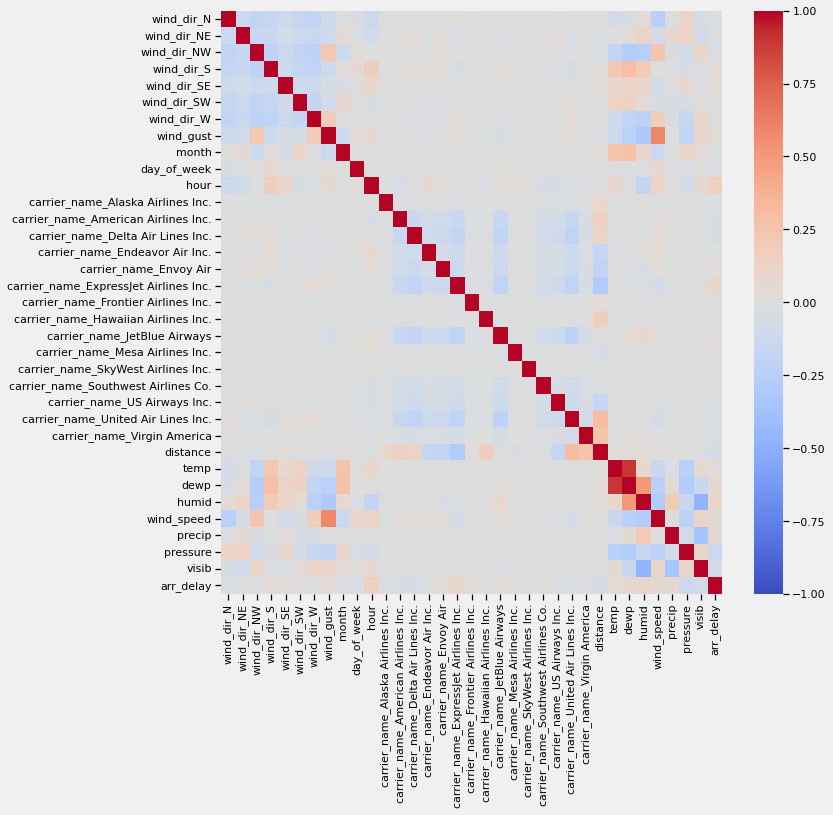

In [85]:
# Wirte your code here
color_map = 'coolwarm'

plt.figure(figsize=(10, 10))
ax = sns.heatmap(
    create_trian_test_features(train, None, return_features=flight_weather_features, 
                               cat_features=cat_features, num_features=num_features, 
                               time_encoding='integer')['train'].corr(),
    annot=False, vmin=-1, vmax=1, center= 0, cmap=color_map)
plt.show()

There is a strong correlation between temperature and dewpoint, which we know can cause problems for our logistic regression model. Let's remove `'dewp'`.

In [86]:
# Flight features
flight_features = ['month', 'hour', 'day_of_week', 'carrier_name', 'distance', 'arr_delay']

# Flight features + weather features
flight_weather_features = flight_features + ['temp', 'humid', 'wind_dir', 'wind_speed', 
                                             'wind_gust', 'precip', 'pressure', 'visib']

We're done feature engineering for now. I'm sure you can think of many other ways to code this up. You'll learn that there are many different ways to do the same thing in Python and some are better than others for a number of reasons (efficiency, readability, modularity, etc.). But what I want to you take away from this section is the importance creating reusable functions to streamline your pipeline and reduce the chance of error.

# 4. Model Building
Ok, we've finsihed cleaning our data and exploring it. We've also built some useful function to streamline our pipeline. Let's quickly recap below.

We created a function `preprocess_data()` to import the individual data files and merge them.

In [87]:
data_modelling = preprocess_data()

Next, we split the data into training and test datasets.

In [88]:
train, test = train_test_split(data_features, train_size=0.8, 
                               test_size=0.2, random_state=0, stratify=data_features['delayed'])

Then, we created a list of flight features and weather features to include.

In [89]:
# Flight features
flight_features = ['month', 'hour', 'day_of_week', 'carrier_name', 'distance', 'arr_delay']

# Flight features + weather features
flight_weather_features = flight_features + ['temp', 'humid', 'wind_dir', 'wind_speed', 
                                             'wind_gust', 'precip', 'pressure', 'visib']

Next, we created two lists to specify which features are numerical and which are categorical.

In [90]:
# Define numerical features to be scaled
num_features = ['distance', 'temp', 'dewp', 'humid', 'wind_speed', 'precip', 'pressure', 'visib', 'arr_delay']

# Define categorical features to be dummy encoded
cat_features = ['carrier_name']

Lastly, we created a function `create_trian_test_features()` to output the final train and test DataFrames for use in training and evaluating the model. 

Here is train

In [91]:
create_trian_test_features(train, test, return_features=flight_weather_features, 
                           cat_features=cat_features, num_features=num_features, 
                           time_encoding='integer')['train'].head(1)

,wind_dir_N,wind_dir_NE,wind_dir_NW,wind_dir_S,wind_dir_SE,wind_dir_SW,wind_dir_W,wind_gust,month,day_of_week,...,carrier_name_United Air Lines Inc.,carrier_name_Virgin America,distance,temp,humid,wind_speed,precip,pressure,visib,arr_delay
29602,0,0,0,0,0,1,0,0,0.909091,0.5,...,1,0,-0.148648,1.283192,-1.314558,-1.398039,-0.107715,-0.049184,0.284163,0.17234


and here is test.

In [92]:
create_trian_test_features(train, test, return_features=flight_weather_features, 
                           cat_features=cat_features, num_features=num_features, 
                           time_encoding='integer')['test'].head(1)

,wind_dir_N,wind_dir_NE,wind_dir_NW,wind_dir_S,wind_dir_SE,wind_dir_SW,wind_dir_W,wind_gust,month,day_of_week,...,carrier_name_United Air Lines Inc.,carrier_name_Virgin America,distance,temp,humid,wind_speed,precip,pressure,visib,arr_delay
316411,1,0,0,0,0,0,0,0,0.818182,0.0,...,0,0,-0.455754,0.057258,0.31519,-0.346778,-0.107715,0.786039,0.284163,-0.614288


Ok, looks great. The first thing we need to do is create a cross-validation function to split our data, train models, and evaluate them. Remember the figure below from the lectures. First, we split the data into `train` and `test` datasets. We then conduct cross-validation on the `train` dataset to choose the ideal set of hyper-parameters, model type, and features. Once the final model is ready, we evaluate it on the `test` data.
<br>
<img src="images/grid_search_cross_validation.png" alt="drawing" width="500"/>
<br>
Now, scikit-learn has some functions for doing cross-validation ([`cross_val_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html#sklearn.model_selection.cross_val_score)), which are very useful. However, we're going to create our own for 3 reasons:
- For learning how to use these tools, its beneficial to see how they work under the hood.
- We want to use our function `create_trian_test_features()` to ensure no leakage between `train` and `test` features. For example, we want the mean and standard deviation for our scaler to come from the training set only. 
- We can record multiple metrics on the validation set.

Let's use our cyclical encoding for time `time_encoding='cyclical'`.

In [93]:
from sklearn.base import clone
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def cross_validate(model, train, n_folds):
    
    # Setup
    model = clone(model)
    five_fold = KFold(n_splits=n_folds)
    cv_output = {'cv_iterations': [], 
                 'mean_val_accuracy': None, 
                 'mean_val_precision': None, 
                 'mean_val_recall': None, 
                 'mean_val_f1': None, 
                 'mean_val_roc_auc': None}
    
    # Iterature thought cv-folds
    for train_index, val_index in five_fold.split(train):
        
        # Get features
        features = create_trian_test_features(train.iloc[train_index, :], train.iloc[val_index, :], 
                                              return_features=flight_weather_features, cat_features=cat_features, 
                                              num_features=num_features, time_encoding='cyclical')

        # Collect data
        cv_data = {'X_train': features['train'], 
                   'y_train': train.iloc[train_index][['delayed']],
                   'X_val': features['test'], 
                   'y_val': train.iloc[val_index][['delayed']]}
        
        # Fit model
        model.fit(cv_data['X_train'], cv_data['y_train'])
        cv_data['model'] = model
        
        # Get train and val accuracy
        cv_data['train_accuracy'] = accuracy_score(cv_data['y_train'], model.predict(cv_data['X_train']))        
        cv_data['val_accuracy'] = accuracy_score(cv_data['y_val'], model.predict(cv_data['X_val']))   
        
        # Get train and val precision
        cv_data['train_precision'] = precision_score(cv_data['y_train'], model.predict(cv_data['X_train']))        
        cv_data['val_precision'] = precision_score(cv_data['y_val'], model.predict(cv_data['X_val']))  
        
        # Get train and val recall
        cv_data['train_recall'] = recall_score(cv_data['y_train'], model.predict(cv_data['X_train']))        
        cv_data['val_recall'] = recall_score(cv_data['y_val'], model.predict(cv_data['X_val']))  
        
        # Get train and val f1
        cv_data['train_f1'] = f1_score(cv_data['y_train'], model.predict(cv_data['X_train']))        
        cv_data['val_f1'] = f1_score(cv_data['y_val'], model.predict(cv_data['X_val']))  
        
        # Get train and val ROCAUC
        cv_data['train_roc_auc'] = roc_auc_score(cv_data['y_train'], model.predict_proba(cv_data['X_train'])[:, 1])        
        cv_data['val_roc_auc'] = roc_auc_score(cv_data['y_val'], model.predict_proba(cv_data['X_val'])[:, 1])  

        # Append cv data
        cv_output['cv_iterations'].append(cv_data)
        
    # Compute average validation metrics
    cv_output['mean_val_accuracy'] = np.mean([cv['val_accuracy']  for cv in cv_output['cv_iterations']])
    cv_output['mean_val_precision'] = np.mean([cv['val_precision']  for cv in cv_output['cv_iterations']])
    cv_output['mean_val_recall'] = np.mean([cv['val_recall']  for cv in cv_output['cv_iterations']])
    cv_output['mean_val_f1'] = np.mean([cv['val_f1']  for cv in cv_output['cv_iterations']])
    cv_output['mean_val_roc_auc'] = np.mean([cv['val_roc_auc']  for cv in cv_output['cv_iterations']])
        
    return cv_output

You can see from the code above, we've structured the output as a with the following form. If `n_folds=5` then there are 5 dictionaries in the list `'cv_iterations': []`. 
```python
{
    'cv_iterations': [{...}, {...}, {...}, {...}, {...}], 
    'mean_val_accuracy': (float) 'Average validation accuracy across all cross-validation iterations.', 
    'mean_val_precision': (float) 'Average validation precision across all cross-validation iterations.', 
    'mean_val_recall': (float) 'Average validation recall across all cross-validation iterations.', 
    'mean_val_f1': (float) 'Average validation f1 across all cross-validation iterations.', 
    'mean_val_roc_auc': (float) 'Average validation ROCAUC across all cross-validation iterations.'
}
```
Each dictionary in `'cv_iterations': []` takes the following form:

```python
{
    'X_train': (DataFrame) 'A DataFrame with the training features for a particular cv iteration.'
    'y_train': (DataFrame) 'A DataFrame with the training labels for a particular cv iteration.'
    'X_val': (DataFrame) 'A DataFrame with the validation features for a particular cv iteration.'
    'y_val': (DataFrame) 'A DataFrame with the validation labels for a particular cv iteration.'
    'model': (scikit-learn model object) 'The trained model object.'
    'train_accuracy': (float) 'Model accuracy for the training dataset.'
    'val_accuracy': (float) 'Model accuracy for the validation dataset.'
    'train_precision': (float) 'Model precision for the training dataset.'
    'val_precision': (float) 'Model precision for the validation dataset.'
    'train_recall': (float) 'Model recall for the training dataset.'
    'val_recall': (float) 'Model recall for the validation dataset.'
    'train_f1': (float) 'Model f1 for the training dataset.'
    'val_f1': (float) 'Model f1 for the validation dataset.'
    'train_roc_auc': (float) 'Model ROCAUC for the training dataset.'
    'val_roc_auc': (float) 'Model ROCAUC for the validation dataset.'
}
```

## Question 4a
You can see that we have output 5 metrics and as we learned in class, some are more appropriate than others depending on the data (balanced or imbalanced) and the application (are false positives bad from a business standpoint?). Consider a hypothetical application, we're conducting an exploratory analysis to assess the feasibility of a model that predicts whether or not a flight will be delayed or cancelled. The usecase is that someone downloads our app on their phone and inputs their flight number. Based on a set of features (month, time of day, airline, weather, etc.) our app will tell the customer if their flight is likely to be delayed or cancelled. 

If you knew your flight was going to be significantly delayed or cancelled, you wouldn't waste your time going to the airport. So, if our app is wrong about the flight being delayed or cancelled then the customer will miss their flight. On the other hand, if our app says the flight is on-time but it is actually delayed or cancelled, then the custumer will have gone to the airport for no reason. Given this usecase and what we know about the class distribution in our dataset, which metric do you think is best for our application/dataset? Please explain your decision.

Write your answer here, replacing this text.

**Answer:** *Our dataset is imbalanced with ~25% of flights being delayed or cancelled. Because the dataset is imbalanced, accuracy is not appropriate. Additionally, the minority class (delayed/cancelled) is the positive class, which renders ROCAUC inappropriate. This leaves `precision`, `recall`, and `F1`. Precision is more focused in the positive class (delayed/cancelled) than in the negative class (not delayed/cancelled) and actually measures the probability of correct detection of the positive classes. Recall is the true positive rate (TPR), which tesst is what fraction of the delayed/cancelled flights we correctly detect. In this case, I would look to use the F1 score, which is the harmonic mean of precision and recall, because both are important for our business case. A model with precision of 100% but a recall of 1% is not going to generate the business value we're looking for.

## Question 4b
First, let's initialize a logistic regression model. Because we do not specify any hyper-parameters in the arguments, the model will be initialized with the default values.

In [94]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()

Next, let's run cross-validation

In [95]:
cv_output = cross_validate(model, train, n_folds=5)

Let's check the average metrics.

In [96]:
print('mean_val_accuracy: {:.2f}'.format(cv_output['mean_val_accuracy']))
print('mean_val_precision: {:.2f}'.format(cv_output['mean_val_precision']))
print('mean_val_recall: {:.2f}'.format(cv_output['mean_val_recall']))
print('mean_val_f1: {:.2f}'.format(cv_output['mean_val_f1']))
print('mean_val_roc_auc: {:.2f}'.format(cv_output['mean_val_roc_auc']))

mean_val_accuracy: 0.91
mean_val_precision: 0.85
mean_val_recall: 0.67
mean_val_f1: 0.75
mean_val_roc_auc: 0.95


By initializing the model like this `model = LogisticRegression()`, the hyper-parameters are set to their default values. Surely we can find better hyper-parameters than this, but how? We're going to try using the grid search approach but there are other approach such as random search and bayesian search. And, there are already functions in sklearn to do this for us ([`GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html), [`RandomizedSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html), [`Bayesian Search`](https://github.com/fmfn/BayesianOptimization)). But, because we're learning, we'll code it up ourselves.|

First, let's take a look at the parameters we can set for `LogisticRegression()` and what their default values are.

In [97]:
model.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

There are quite a few hyper-paramters we could tune, but for this question, we'll focus on `C`, `class_weight`, and `penalty`. The dictionary `hyper_param_grid` contains a list of values for each of the hyper-parameters. Learn more about the `LogisticRegression()` hyper-parameters [here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html). But here are the descriptions for the three we're focusing on.

`C` 
- float
- default=1.0
- Inverse of regularization strength; must be a positive float. Smaller values specify stronger regularization.


`class_weight`
- `dict` or `'balanced'
- default=None
- The `'balanced'` mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as n_samples / (n_classes * np.bincount(y)).
- You'll remember in the lectures we discussed using the `class_weight` hyper-parameter to compensate for an imbalanced dataset.

`penalty`
- {‘l1’, ‘l2’, ‘elasticnet’, ‘none’}
- default=’l2’
- Specify the norm of the penalty: 'none': no penalty is added; 'l2': add a L2 penalty term and it is the default choice; 'l1': add a L1 penalty term; 'elasticnet': both L1 and L2 penalty terms are added.`
- In the lectures, we discussed L1 and L2 regularization but in this question, we're only testing L2 because the default solver does not work for L1 regularization.

In [103]:
hyper_param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                    'class_weight': [None, 'balanced'],
                    'penalty': ['none', 'l2']}

For this question, you must complete the function `grid_search()` below so that it performs a grid search hyper-parameter optimization over the hyper-parameters and values in `hyper_param_grid`. The function should train a model for each combination of `C`, `class_weight`, and `penalty`. For example: 

- Model 1:  `C = 0.001`, `class_weight = None`, `penalty = 'none'`
- Model 1:  `C = 0.001`, `class_weight = None`, `penalty = 'l2'`
- Model 1:  `C = 0.001`, `class_weight = 'balanced`, `penalty = 'none'`
- Model 1:  `C = 0.001`, `class_weight = balanced`, `penalty = 'l2'`
- ...

Of course, those hyper-parameters should be used to initialize the model and this will mean a total of 28 models will be trained. For each combination of `C`, `class_weight`, and `penalty`, you should run 5-fold cross-validation using `cross_validate(model, train, n_folds=5)`. The output from `grid_search()` should be a DataFrame with 28 rows and four columns: `C`, `class_weight`, `penalty`, `score`. `score` should be the average `F1` score across all cross-validation folds. This is `'mean_val_f1'` in output from `cross_validate(model, train, n_folds=5)`. The DataFrame should be sorted in descending order by `'score'`.  

Your answers should look like this.
<br>
<img src="images/q4c.png" alt="drawing" width="300"/>
<br>

Warning: This could take a bit of time (~5 minutes) because of we have to train 28*5 models. Be patient.

In [106]:
import itertools

def grid_search(train, hyper_param_grid):
    
    # Get a sample from the training data
    train_sample = train.sample(frac=0.25)
    
    # List for output
    output = list()
    
    # Write your code here
    
    # Get a list of dictionaries will all combinations of hyper-parameters
    combinations = [{hyper_param: combination[idx] for idx, hyper_param in enumerate(hyper_param_grid)} 
                    for combination in list(itertools.product(hyper_param_grid['C'], hyper_param_grid['class_weight'], 
                                                              hyper_param_grid['penalty']))]
     
    # Loop through combinations
    for combination in combinations:
        
        # Initialize model with hyper-parameters
        model = LogisticRegression(**combination)
        
        # Run cross-validation
        cv_output = cross_validate(model, train, n_folds=5)
        
        # Add the mean f1 score to the combination dictionary
        combination.update({'score': cv_output['mean_val_f1']})
        
        # Add dictionary to list
        output.append(combination)

    return pd.DataFrame(output).sort_values(by='score', ascending=False)

Let's try the function.

In [107]:
grid_search_results = grid_search(train, hyper_param_grid)

Let's print the output

In [108]:
grid_search_results

,C,class_weight,penalty,score
3,0.001,balanced,l2,0.754429
7,0.010,balanced,l2,0.751012
23,100.000,balanced,l2,0.750593
27,1000.000,balanced,l2,0.750591
15,1.000,balanced,l2,0.750591
10,0.100,balanced,none,0.750586
26,1000.000,balanced,none,0.750586
22,100.000,balanced,none,0.750586
18,10.000,balanced,none,0.750586
14,1.000,balanced,none,0.750586


As we can see, the following combination of `C=0.001`, `class_weight='balanced'`, `penalty='l2` produced the highest validation `F1` score of 0.75. We should use these hyper-parameters moving forward.

## Question 4c
You'll recall from the lectures the concept of the bias-variance trade-off, how to diagnose it, and how to address it. The figure below shows the training error and validation error as a function of model complexity.
<br>
<img src="images/b_v_tradeoff.png" alt="drawing" width="400"/>
<br>
Initialize a logistic regression model. Because we do not specify any hyper-parameters in the arguments, the model will be initialized with the default values.

In [110]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(C=0.001, class_weight='balanced', penalty='l2')

Use the space below to explore the cross-validation output `cv_output`.

In [111]:
cv_output = cross_validate(model, train, n_folds=5)

In [112]:
# Example of printing accuracy
for idx, val in enumerate(cv_output['cv_iterations']):
    print('cv {}\ntrain accuracy: {}\nval accuracy: {}\n'.format(idx+1, val['train_accuracy'], val['val_accuracy']))

cv 1
train accuracy: 0.8909077930065015
val accuracy: 0.8890353189246178

cv 2
train accuracy: 0.8909846687752592
val accuracy: 0.890990159901599

cv 3
train accuracy: 0.8900401950448076
val accuracy: 0.8914733790195045

cv 4
train accuracy: 0.8908968107538219
val accuracy: 0.8885740643120716

cv 5
train accuracy: 0.890259840098401
val accuracy: 0.8930108943946582


In [113]:
# Write your code here
for idx, val in enumerate(cv_output['cv_iterations']):
    print('cv {}\ntrain f1: {}\nval f1: {}\n'.format(idx+1, val['train_f1'], val['val_f1']))

cv 1
train f1: 0.7552209750748493
val f1: 0.7509858044164038

cv 2
train f1: 0.7551279679309281
val f1: 0.7544406511305723

cv 3
train f1: 0.7530795694151593
val f1: 0.7580194916499339

cv 4
train f1: 0.7547551748398482
val f1: 0.7515062454077883

cv 5
train f1: 0.7540640651727151
val f1: 0.757190568765266


When looking at the `f1 score` for the `train` and `val` data for all `cv` iterations, would you say that we have a `bias` problem, a `variance` problem, or neither. If we have a `bias` or `variance` problem, please explain where on the figure above the results are (left or right) and at least two possible solutions. 

Write your answer here, replacing this text.

**Answer:** *In this case, we have a bias problem. We can see that the train and val f1 scores are very similar and that the train f1 score is ~75%, which is far below 100%. Additionally, the variability across cv iterations is small. This suggest that the model is not complex enough to model the training data. Some ways to increase the complexity of the model are: (1) try a more complext model such as a `Random Forest`, (2) Add more features, (3) Add non-linear (polynomial) features, (4) Reduce or remove any regularlization terms.* 

## Question 4d
It can be helpful to conduct a feature importance analysis so see which features are diving the model's predictions. This can be helpful for two reasons: (1) Your model will become less of a black box and the results may help your explain how the model works to business stakeholders and (2) You can use it to debug your model. You can extract feature importance using a number of methods, which often depend on the type of model. We won't use it in this assignment, but [SHAP](https://github.com/slundberg/shap) is worth checking out. We will be looking at the coefficients of our linear model.

You can check the coefficients using the `.coef_` attribute of `LogisticRegression()`. Here we are selecting the model from the first cross-validation iteration.

In [114]:
cv_output['cv_iterations'][0]['model'].coef_

array([[-4.45705970e-03, -5.88620833e-02, -7.91776555e-03,
        -6.30537851e-02, -5.98497477e-02,  1.41601210e-01,
         1.21177741e-01, -5.24771941e-02,  5.77189699e-02,
        -1.17070054e-01, -8.26975426e-02, -5.55043209e-02,
        -5.41659498e-01,  6.43899017e-02,  3.52201018e-03,
        -1.34112875e-01, -1.06959648e-01,  2.29880446e-01,
        -1.98874737e-01,  2.22545342e-01, -9.31291415e-03,
        -5.52731898e-03, -3.40825221e-02,  2.42964475e-03,
        -2.53481944e-03,  2.60961635e-01, -3.27580814e-01,
         1.48639476e-01,  4.39432888e-03,  9.11638752e-02,
         6.14738656e-02,  1.04633334e-01,  2.84339671e-02,
         1.22012666e-02,  2.35254917e-04,  3.42541660e-02,
         2.99518433e+00]])

Let's add the column names, take the absolute value of the coefficients, add the sign, wrap if up in a DataFrame and sort in descending order.

In [115]:
pd.DataFrame({'features': cv_output['cv_iterations'][0]['X_train'].columns, 
              'abs(coefficients)': np.abs(cv_output['cv_iterations'][0]['model'].coef_[0]),
              'sign': np.sign(cv_output['cv_iterations'][0]['model'].coef_[0]).astype(int)}).sort_values(by='abs(coefficients)', 
                                                                                                         ascending=False)

,features,abs(coefficients),sign
36,arr_delay,2.995184,1
12,hour_sin,0.541659,-1
26,carrier_name_US Airways Inc.,0.327581,-1
25,carrier_name_Southwest Airlines Co.,0.260962,1
17,carrier_name_Endeavor Air Inc.,0.229880,1
19,carrier_name_ExpressJet Airlines Inc.,0.222545,1
18,carrier_name_Envoy Air,0.198875,-1
27,carrier_name_United Air Lines Inc.,0.148639,1
5,wind_dir_SW,0.141601,1
15,carrier_name_American Airlines Inc.,0.134113,-1


`'arr_delay'` appears to be significantly more predictive than the rest of the features. You'll remember `'arr_delay'` is the arrival delay in minutes where negative times represent early arrivals. Please discuss why `'arr_delay'` is so predictive and if we should keep it as a feature. Please explain your decision. You're welcome to include code, tables, and figures but it is not required.

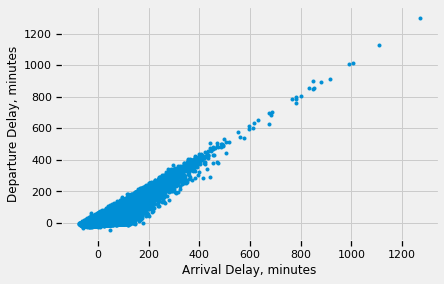

In [116]:
# Write your code here
plt.plot(train['arr_delay'], train['dep_delay'], '.')
plt.xlabel('Arrival Delay, minutes')
plt.ylabel('Departure Delay, minutes');

Write your answer here, replacing this text.

**Answer:** *`'arr_delay'` and `'dep_delay'` are highly correlated. This is because flights that have a delayed departure are likely to have a delayed arrival. By including `'arr_delay'` as a feature, we are introducing target leakage. Target leakage occurs when your features include data that will not be available at the time you make predictions. It is important to think about target leakage in terms of the timing or chronological order that data becomes available, not merely whether a feature helps make good predictions. We should remove `'arr_delay'` from our features.* 

Ok, we should remove `'arr_delay'` from our features (but you need to tell us why!). Let's do that now.

In [117]:
# Flight features
flight_features = ['month', 'hour', 'day_of_week', 'carrier_name', 'distance']

# Flight features + weather features
flight_weather_features = flight_features + ['temp', 'humid', 'wind_dir', 'wind_speed', 
                                             'wind_gust', 'precip', 'pressure', 'visib']

Next, let's initialize our logistic regression model again and conduct cross-validation.

In [118]:
model = LogisticRegression()
cv_output = cross_validate(model, train, n_folds=5)

Let's look at the `F1` score for each cross-validation iteration.

In [119]:
for idx, val in enumerate(cv_output['cv_iterations']):
    print('cv {}\ntrain f1: {}\nval f1: {}\n'.format(idx+1, val['train_f1'], val['val_f1']))

cv 1
train f1: 0.12258651646702905
val f1: 0.12059902806704353

cv 2
train f1: 0.1171193497224425
val f1: 0.1146080760095012

cv 3
train f1: 0.1163384119905859
val f1: 0.11775218427323272

cv 4
train f1: 0.11551269943834187
val f1: 0.1158308751229105

cv 5
train f1: 0.11846397153306315
val f1: 0.11901219875037193


Wow, that's a big change from before. When we included `'arr_delay'` in our features, the cross-validation `F1` score was ~75% and now its 11%!

Clearly we've got more work to do and I'm sorry to end on such a sour note but I do want to convey that Data Science is hard and its not always possible to generate a model that is performant or satisfies the business requirements. 

You should also notice that we have not evaluated our model on the `test` data. This is only done when we're satisfied with out model and clearly we're not there yet.

Something obvious next steps are: (1) Read some papers about flight delays. I'm sure some domain knowledge would be helpful here, (2) Explore new features or datasets. We never used the `planes.csv` dataset but maybe the plane model is correlated with delays, (3) Read other machine learning papers about flight delay prediction, (4) Try more complex models like Random Forest, XGBoost, or neural networks, (5) Revist the training target. Perhaps the 15 minute delay is not significant enough. But, make sure to check with the business/product team.

**Congratulation, you're done Assignment 9. Review your answers and clean up that code before submitting on Quercus. `#cleancode`**